In [153]:
import torch
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm
from scipy.integrate import solve_bvp
from scipy.optimize import minimize, fsolve, brentq


import os
import re

os.chdir("/home/s2113174/Projects-1")

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric PDE

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{10} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

## The Problem consist in infering $ \alpha $

[ 2.15374797  4.57785946  7.28719433 10.17397019 13.15666747 16.19232721
 19.25912069 22.34541174 25.44459754 28.55270584] [-0.17497922 -0.19162088 -0.23675579] [ 5.1250785  -4.88035327  1.75560544]


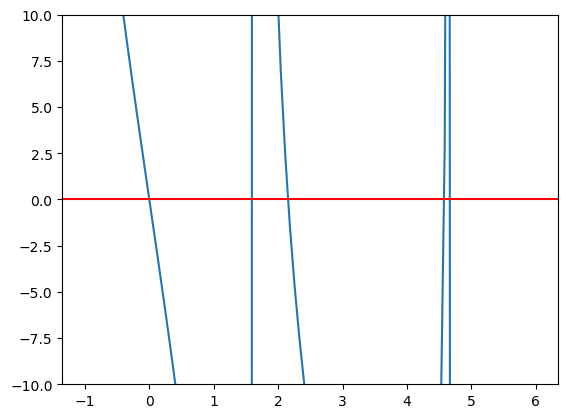

In [154]:
import scipy.optimize as opt

ns = 1
t= np.linspace(0,ns,1000)
mean, std = 0,np.sqrt(1e-4)

w = np.linspace(-1,6,100)

def tang_eq(x):
    return (x**2 - 16)*np.tan(x) - 8*x

# roots = []
# for i in [(1,2),(2,3)]:
#     roots.append(opt.bisect(tang_eq,i[0],i[1]))

########################################################################################
def roots_f(lam,M): #find solution of transcendental equation
    c = 1/lam
    g = lambda x: (np.tan(x) - (2*c*x)/(x**2-c**2))
    m = 1
    answer = np.zeros(M+1)
    for i in range(M):
        wmin = (i-0.499) * np.pi
        wmax = (i+0.499) * np.pi
        if wmin <= c and wmax >= c:
            if wmin > 0:
                answer[m] = fsolve(g, (c+wmin)/2)
                m = m + 1
            answer[m] = fsolve(g, (c+wmax)/2)
            m = m + 1
        elif wmin > 0:
            answer[m] = brentq(g,wmin,wmax)
            m = m + 1
    omega = answer[1:]
    return omega

lam = 1/4
#omega = roots(lam,2)
###################################################################################

roots = np.array(roots_f(lam,10))
theta_t = np.array([0.09762701, 0.43037873, 0.20552675, 0.08976637, -0.1526904, 0.29178823, -0.12482558, 0.783546, 0.92732552, -0.23311696])

plt.plot(w, tang_eq(w))
plt.axhline(y = 0, color = 'r', linestyle = '-') 
plt.ylim(-10,10)


def k(x,theta,w):
    x = x.reshape(-1,1)

    A = np.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (np.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (np.cos(2*w)/8)))
    
    bn =  A*(np.sin(w*x) + ((w)/(4))*np.cos(w*x))
    
    an = np.sqrt(8 / (w**2 + 16))
    
    return np.sum(an*bn*theta,axis=1)

def dk(x,theta,w):
    x = x.reshape(-1,1)

    A = np.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (np.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (np.cos(2*w)/8)))
    
    bn =  A*w*(((w)/(4))*np.sin(w*x) - np.cos(w*x))

    an = np.sqrt(8 / (w**2 + 16))

    return np.sum(an*bn*theta,axis=1)


print(roots, k(np.array([0.6,0.7,0.9]),theta_t,roots), dk(np.array([0.6,0.7,0.9]),theta_t,roots))

In [155]:
def fun_shock(x, y):

    def k(x,theta = theta_t,w =roots):
        x = x.reshape(-1,1)

        A = np.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (np.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (np.cos(2*w)/8)))
        
        bn =  A*(np.sin(w*x) + ((w)/(4))*np.cos(w*x))
        
        an = np.sqrt(8 / (w**2 + 16))

        return np.sum(an*bn*theta,axis=1)

    def dk(x,theta = theta_t,w =roots):
        x = x.reshape(-1,1)

        A = np.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (np.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (np.cos(2*w)/8)))
        
        bn =  A*w*(((w)/(4))*np.sin(w*x) - np.cos(w*x))
        
        an = np.sqrt(8 / (w**2 + 16))

        return np.sum(an*bn*theta,axis=1)
        
    return np.vstack(( y[1], -(4*x*np.exp(-k(x)) + dk(x)*y[1]) ))

def bc_shock(ya, yb):
    return np.array([ya[0], yb[0] - 2])

x_shock = np.linspace(0, 1, 20)
y_shock = np.zeros((2, x_shock.shape[0]))

In [156]:
res_shock = solve_bvp(fun_shock, bc_shock, x_shock, y_shock, verbose=2)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.75e-02       3.91e-17          20             18       
       2          1.98e-02       6.78e-19          38             23       
       3          4.25e-03       2.67e-20          61              6       
       4          9.99e-04       2.26e-22          67              0       
Solved in 4 iterations, number of nodes 67. 
Maximum relative residual: 9.99e-04 
Maximum boundary residual: 2.26e-22


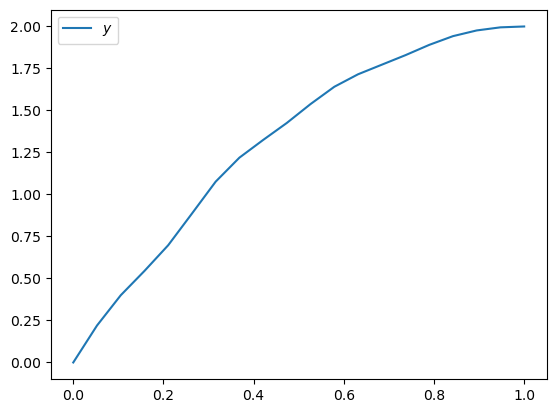

In [157]:
x_shock_plot = np.linspace(0, 1, 20)
y_shock_plot = res_shock.sol(x_shock_plot)

plt.plot(x_shock_plot, y_shock_plot[0], label='$y$')
plt.legend()

In [158]:
def test_set(max_space,obs,mean,std):

    t = np.linspace(0,max_space,obs)

    sol = res_shock.sol(t)

    noise_sol_test = sol[0] + np.random.normal(mean,std, len(t))

    return t, noise_sol_test

## Feed Forward Neural Network

In [159]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        for param in self.parameters():
            if len(param.shape) > 1:
                torch.nn.init.xavier_normal_(param)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric PINN for Inverse Problems

In [160]:
def DE(self,t,pr,roots = torch.tensor(roots).float()):
    """ The pytorch autograd version of calculating residual """

    u = self(torch.cat([t, pr], dim=1))
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t, t, 
        grad_outputs=torch.ones_like(u_t),
        retain_graph=True,
        create_graph=True
    )[0]
    
    def k(x,theta,w):

        A = torch.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (torch.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (torch.cos(2*w)/8)))
    
        bn =  A*(torch.sin(w*x) + ((w)/(4))*torch.cos(w*x))
    
        an = torch.sqrt(8 / (roots**2 + 16))

        return an*bn*theta
    
    def dk(x,theta,w):
        
        A = torch.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (torch.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (torch.cos(2*w)/8)))
    
        bn =  A*w*(-torch.cos(w*x) + ((w)/(4))*torch.sin(w*x))
    
        an = torch.sqrt(8 / (roots**2 + 16))

        return an*bn*theta

    dk_sum = torch.sum(dk(t,pr,roots),dim=1).reshape(-1,1)
    exp_k = torch.exp(torch.sum(k(t,pr,roots),dim=1)).reshape(-1,1)

    return dk_sum*exp_k*u_t + exp_k*u_tt + 4*t

In [161]:
DNN.DE = DE

In [162]:
def sample_ic(size):
    return np.zeros(size)

def sample_bc(size):
    return np.ones(size)

def samples_space(size,maxl):
    t_f_train = lhs(1, size)*maxl
    return t_f_train

# def samples_param(min,max,size = 100):
#     return min + np.random.rand(size)*(max - min)

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [163]:
def data_pde(size,maxl,minp,maxp):

    t, param = samples_space(size,maxl),samples_param(minp,maxp,(size,theta_t.shape[0]))

    X_u_train = torch.from_numpy(np.concatenate((t.reshape(-1,1),param),axis=1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))
    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

def data_ic(size):
    ic = sample_ic(size)

    X_u_train = torch.from_numpy(ic.reshape(-1,1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))
    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

def data_bc(size):
    bc = sample_bc(size)

    X_u_train = torch.from_numpy(bc.reshape(-1,1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))
    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

In [164]:
def train_a(epochs, pinn,loss,optimizer,size,maxl,minp,maxp):
    t_n,param_n = [],[]
    print("Starting Training")

    for i in range(epochs):
        data_pde_, data_ic_,data_bc_ = data_pde(size,maxl,minp,maxp),data_ic(size),data_bc(size)

        for (x, y),(ic,yic),(bc,ybc) in zip(data_pde_, data_ic_, data_bc_):
            t_n.append(x[:,0]); param_n.append(x[:,1:])

            ic, bc ,t = Variable(ic,requires_grad=True).reshape(-1,1),Variable(bc,requires_grad=True).reshape(-1,1), Variable(x[:,0],requires_grad=True).reshape(-1,1)
            param =  Variable(x[:,1:],requires_grad=True)

            for _ in range(10):
            
                optimizer.zero_grad()

                ic_pred,bc_pred,f_pred = pinn(torch.cat([ic, param], dim=1)), pinn(torch.cat([bc, param], dim=1)),pinn.DE(t,param)

                loss_u_ic,loss_u_bc,loss_f = loss(ic_pred,torch.zeros_like(t)),loss(bc_pred,torch.ones_like(t)*2),loss(f_pred,torch.zeros_like(t))

                Loss =  loss_f + loss_u_ic + loss_u_bc

                if _ % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_bc: %.5e, Loss_f: %.5e' % (i+_, Loss.item(),loss_u_ic.item(),loss_u_bc.item(), loss_f.item()))
                    
                Loss.backward() 

                optimizer.step() 

                #sheduler.step()
    return t_n,param_n

In [165]:
def train_2a(pinn,loss,optimizer,size,maxl,minp,maxp):
    
    print("Starting Training")

    ic,bc, t, param = sample_ic(size),sample_bc(size),samples_space(size,maxl),samples_param(minp,maxp,(size,theta_t.shape[0]))

    ic, bc, t = torch.tensor(ic).float().to(device),torch.tensor(bc).float().to(device), torch.tensor(t).float().to(device)
    param = torch.tensor(param).float().to(device) 

    ic, bc ,t = Variable(ic,requires_grad=True).reshape(-1,1),Variable(bc,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1)
    param =  Variable(param,requires_grad=True)

        
    def loss_func_train():
        
        optimizer.zero_grad()

        ic_pred,bc_pred,f_pred = pinn(torch.cat([ic, param], dim=1)), pinn(torch.cat([bc, param], dim=1)),pinn.DE(t,param)

        loss_u_ic,loss_u_bc,loss_f = loss(ic_pred,torch.zeros_like(t)),loss(bc_pred,torch.ones_like(t)*2),loss(f_pred,torch.zeros_like(t))

        Loss =  loss_f + loss_u_ic + loss_u_bc

        print('Loss: %.5e, Loss_ic: %.5e, Loss_bc: %.5e, Loss_f: %.5e' % (Loss.item(),loss_u_ic.item(),loss_u_bc.item(), loss_f.item()))
            
        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 

In [166]:
# def train(epochs, pinn,loss,optimizer,size,maxl,minp,maxp):
   
#    print("Starting Training")

#    for i in range(epochs):

#     ic,bc, t, param = sample_ic(size),sample_bc(size),samples_space(size,maxl),samples_param(minp,maxp,(size,theta_t.shape[0]))

#     ic, bc, t = torch.tensor(ic).float().to(device),torch.tensor(bc).float().to(device), torch.tensor(t).float().to(device)
#     param = torch.tensor(param).float().to(device) 

#     ic, bc ,t = Variable(ic,requires_grad=True).reshape(-1,1),Variable(bc,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1)
#     param =  Variable(param,requires_grad=True)

#     for _ in range(10):
       
#         optimizer.zero_grad()

#         ic_pred,bc_pred,f_pred = pinn(torch.cat([ic, param], dim=1)), pinn(torch.cat([bc, param], dim=1)),pinn.DE(t,param)

#         loss_u_ic,loss_u_bc,loss_f = loss(ic_pred,torch.zeros_like(t)),loss(bc_pred,torch.ones_like(t)*2),loss(f_pred,torch.zeros_like(t))

#         Loss =  loss_f + loss_u_ic + loss_u_bc

#         if _ % 10 == 0:
#                 print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_bc: %.5e, Loss_f: %.5e' % (i+_, Loss.item(),loss_u_ic.item(),loss_u_bc.item(), loss_f.item()))
            
#         Loss.backward() 

#         optimizer.step() 

#         #sheduler.step()

In [167]:
# def train_2(pinn,loss,optimizer,size,maxl,minp,maxp):
    
#     print("Starting Training")

#     ic,bc, t, param = sample_ic(size),sample_bc(size),samples_space(size,maxl),samples_param(minp,maxp,(size,theta_t.shape[0]))

#     ic, bc, t = torch.tensor(ic).float().to(device),torch.tensor(bc).float().to(device), torch.tensor(t).float().to(device)
#     param = torch.tensor(param).float().to(device) 

#     ic, bc ,t = Variable(ic,requires_grad=True).reshape(-1,1),Variable(bc,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1)
#     param =  Variable(param,requires_grad=True)

        
#     def loss_func_train():
        
#         optimizer.zero_grad()

#         ic_pred,bc_pred,f_pred = pinn(torch.cat([ic, param], dim=1)), pinn(torch.cat([bc, param], dim=1)),pinn.DE(t,param)

#         loss_u_ic,loss_u_bc,loss_f = loss(ic_pred,torch.zeros_like(t)),loss(bc_pred,torch.ones_like(t)*2),loss(f_pred,torch.zeros_like(t))

#         Loss =  loss_f + loss_u_ic + loss_u_bc

#         print('Loss: %.5e, Loss_ic: %.5e, Loss_bc: %.5e, Loss_f: %.5e' % (Loss.item(),loss_u_ic.item(),loss_u_bc.item(), loss_f.item()))
            
#         Loss.backward() 

#         return Loss

#     optimizer.step(loss_func_train) 

In [168]:
# Number of observations
epochs = 5000
nobs = 6000
lr = 0.001

min_param , max_param = -1, 1

space = 1

layers = [11] + 4*[50] + [1]


model = DNN(layers)
loss = torch.nn.MSELoss(reduction ='mean')

In [169]:
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# #scheduler = lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.3)

# train(epochs, model,loss,optimizer,nobs,space,min_param,max_param)

In [170]:
# optimizer = torch.optim.LBFGS(
#     model.parameters(), lr=lr, max_iter=10000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
#     )

# train_2(model,loss,optimizer,nobs,space,min_param,max_param)

model.load_state_dict(torch.load("../Projects-1/Physics _Informed_NN/Models/Param_model_T4.pt"))
model.eval()

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=11, out_features=50, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=50, out_features=50, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=50, out_features=50, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=50, out_features=50, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [171]:
#torch.save(model.state_dict(),"Param_model_T4.pt")

In [172]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

data_pde_ = data_pde(nobs,space,min_param , max_param)

t,param = next(iter(data_pde_))

t, param = Variable(t[:,0].reshape(-1,1),requires_grad=True),Variable(t[:,1:],requires_grad=True)

f_pred = model.DE(t,param)

h1.remove()

loss_f = loss(f_pred,torch.zeros_like(f_pred))

df_f_1 = grad(loss_f, f_pred, create_graph=True)[0]

ddf_ff_1 = grad(df_f_1, f_pred, torch.ones_like(df_f_1))[0]

df_theta_1 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_1)),1)

print(df_theta_1)

tensor([[-0.9887, -0.9297, -0.1840,  ...,  0.9968, -0.9505,  1.0000],
        [-0.9884, -0.8935, -0.2968,  ...,  0.9992, -0.9732,  1.0000],
        [-0.9929, -0.8016, -0.0764,  ...,  0.9995, -0.9848,  1.0000],
        ...,
        [-0.9839, -0.7465,  0.2365,  ...,  0.9994, -0.9831,  1.0000],
        [-0.9924, -0.8884,  0.1843,  ...,  0.9977, -0.9613,  1.0000],
        [-0.9875, -0.8114,  0.3498,  ...,  0.9993, -0.9768,  1.0000]])


In [173]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

ic_pred = model(torch.cat([torch.zeros_like(t), param],dim=1))

h1.remove()

loss_u_ic = loss(ic_pred,torch.zeros_like(ic_pred))

df_f_2 = grad(loss_u_ic, ic_pred, create_graph=True)[0]

ddf_ff_2 = grad(df_f_2, ic_pred, torch.ones_like(df_f_1))[0]

df_theta_2 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_2)),1)

print(df_theta_2)

tensor([[-0.9841, -0.1882,  0.4665,  ...,  0.9994, -0.9816,  1.0000],
        [-0.9774, -0.1639,  0.2534,  ...,  0.9994, -0.9845,  1.0000],
        [-0.9848, -0.1887,  0.1989,  ...,  0.9994, -0.9860,  1.0000],
        ...,
        [-0.9605, -0.0268,  0.5834,  ...,  0.9996, -0.9852,  1.0000],
        [-0.9814, -0.1848,  0.6042,  ...,  0.9992, -0.9807,  1.0000],
        [-0.9712, -0.0876,  0.6271,  ...,  0.9995, -0.9812,  1.0000]])


In [174]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

bc_pred = model(torch.cat([torch.ones_like(t)*2, param],dim=1))

h1.remove()

loss_u_bc = loss(bc_pred,torch.zeros_like(bc_pred))

df_f_3 = grad(loss_u_bc, bc_pred, create_graph=True)[0]

ddf_ff_3 = grad(df_f_3, bc_pred, torch.ones_like(df_f_1))[0]

df_theta_3 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_2)),1)

print(df_theta_3)

tensor([[-0.5829, -0.8389, -0.1638,  ..., -0.9993,  0.9577,  1.0000],
        [-0.4363, -0.8310, -0.3668,  ..., -0.9992,  0.9581,  1.0000],
        [-0.5580, -0.8657, -0.2648,  ..., -0.9993,  0.9601,  1.0000],
        ...,
        [-0.5448, -0.8473, -0.1680,  ..., -0.9993,  0.9615,  1.0000],
        [-0.6371, -0.8611, -0.1346,  ..., -0.9995,  0.9612,  1.0000],
        [-0.5760, -0.8616, -0.1606,  ..., -0.9993,  0.9610,  1.0000]])


In [175]:
wt,bias = model.layers[-1].weight, model.layers[-1].bias

param_MAP = torch.cat((wt,bias.reshape(1,1)),1) 

nparam = param_MAP.reshape(-1).shape

print(df_theta_1.shape,df_theta_2.shape,df_theta_3.shape,nparam)

torch.Size([6000, 51]) torch.Size([6000, 51]) torch.Size([6000, 51]) torch.Size([51])


In [176]:
H = (nobs/2)*(torch.sum(df_theta_1*ddf_ff_1*df_theta_1,axis=0)+ torch.sum(df_theta_2*ddf_ff_2*df_theta_2,axis=0)+torch.sum(df_theta_3*ddf_ff_3*df_theta_3,axis=0))

print(H,H.shape)

tensor([13324.6680,  9162.3047,  3032.3074, 16016.1396,  8448.7539,  7435.1265,
         9888.4297, 11607.3633,  4639.2061, 13299.4795,  9898.3711, 13001.5098,
         5552.0894, 11046.6104, 12183.0625,  7460.1533,  8522.2549, 11026.7803,
        12053.9062, 13571.9014, 16515.9473, 11515.8174,  8241.3828,  9066.7842,
        14970.3652, 16083.8057,  5667.0615, 12393.0615,  7619.2759, 15249.5889,
        16237.8203, 11954.8154, 12299.3701, 16199.4727, 10662.6973,  8559.0859,
        10283.1025, 14081.0020, 10302.1562,  8804.5137, 11032.1592, 14046.2812,
         8194.6924, 15667.5215, 16817.7793, 13583.2568,  6370.1592, 15611.3721,
        16636.4648, 15400.7266, 18000.0020]) torch.Size([51])


In [177]:
_sigma_noise=torch.tensor([1])
temperature=torch.tensor([1])

def sigma_noise():
    return _sigma_noise

def _H_factor():
    sigma2 = sigma_noise().square()
    return 1 / sigma2 / temperature

def prior_precision_diag(prior_precision,n_params):
    """Obtain the diagonal prior precision \\(p_0\\) constructed from either
    a scalar, layer-wise, or diagonal prior precision.

    Returns
    -------
    prior_precision_diag : torch.Tensor
    """
    if len(prior_precision) == 1:  # scalar
        return prior_precision * torch.ones(n_params, device=device)

    elif len(prior_precision) == n_params:  # diagonal
        return prior_precision

    # elif len(prior_precision) == n_layers:  # per layer
    #     n_params_per_layer = parameters_per_layer(self.model)
    #     return torch.cat([prior * torch.ones(n_params, device=self._device) for prior, n_params
    #                         in zip(self.prior_precision, n_params_per_layer)])

    # else:
    #     raise ValueError('Mismatch of prior and model. Diagonal, scalar, or per-layer prior.')

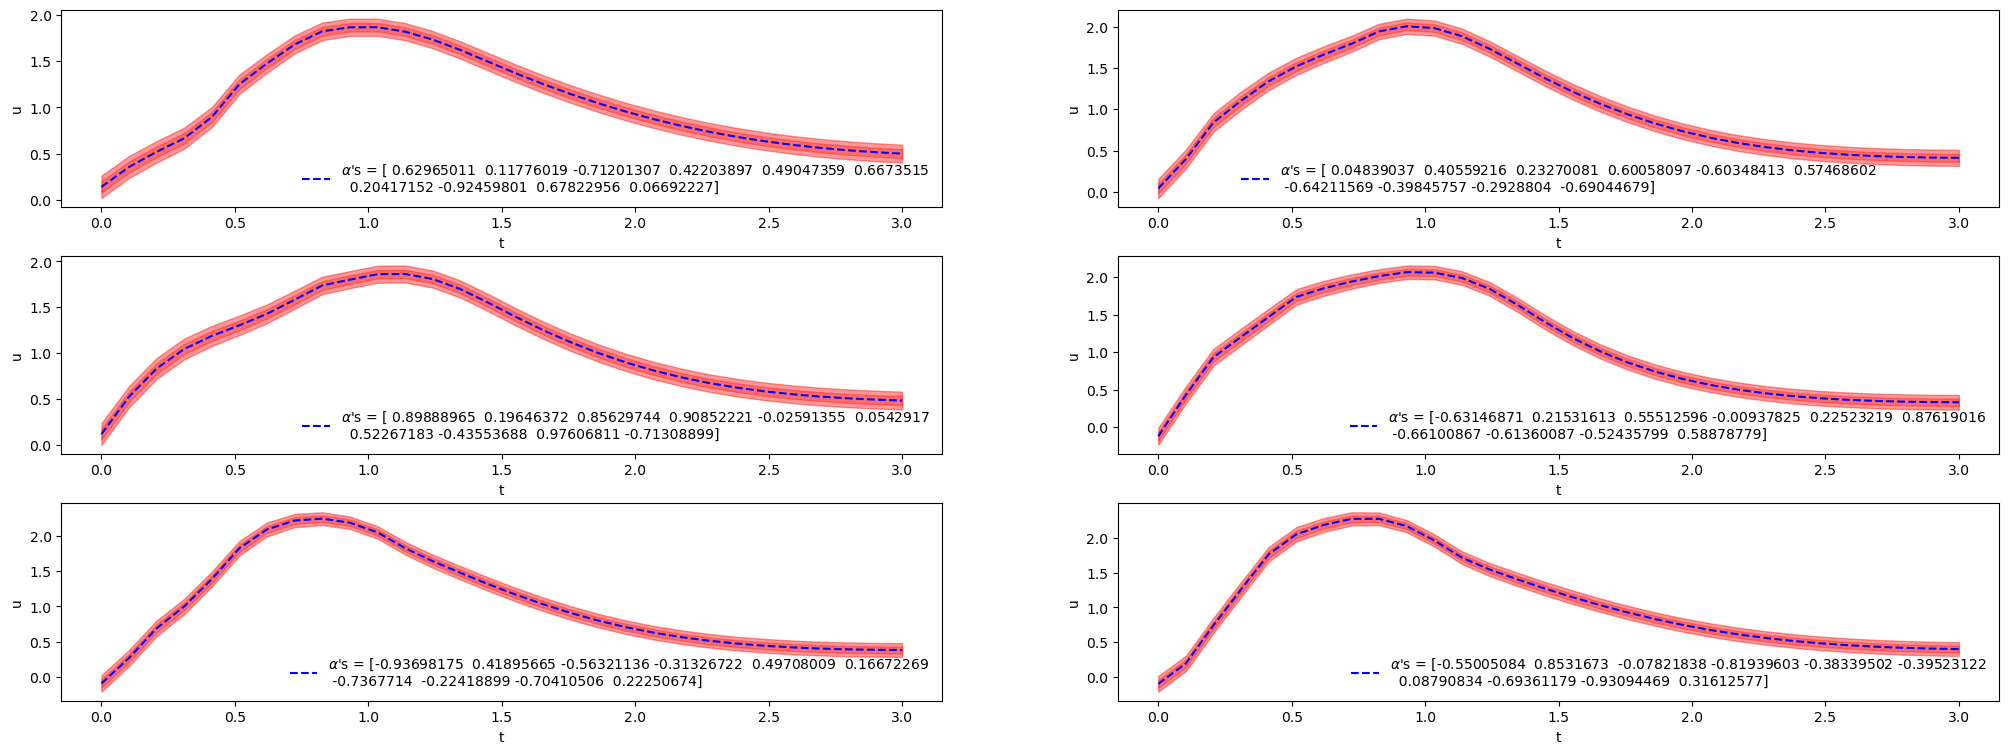

In [201]:
import matplotlib.pyplot as plt
from matplotlib import cm


param_trained =  samples_param(min_param , max_param,(6,theta_t.shape[0]))
ns, mean, std = 3, 0,0.2


prior_pre=torch.tensor([1/ std**2])

prior_pre_diag = prior_precision_diag(prior_pre,nparam)

# Plotting
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.25)

for n,pr in enumerate(param_trained):
    t, noise_sol_test = test_set(ns,30,mean,std)

    data_test = np.hstack((t.reshape(-1,1),np.ones((t.shape[0],theta_t.shape[0]))*(pr.flatten())))


    ######################################################################################

    forw_activation_ = {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

    f  = model(torch.tensor(data_test).float()).detach().cpu().numpy()

    h1.remove()

    phi = forw_activation['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * H + prior_pre_diag


    post_variance = 1 / post_presicion

    functional_var = torch.einsum('ncp,p,nkp->nck', Js, post_variance, Js)

    #######################################################################################
    f_mu = f.reshape(-1)
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy().reshape(-1)
    
    plt.subplot(8, 2, n + 1)

    #plt.scatter(t,noise_sol_test, label = "Observations",color= "blue",alpha = 0.5)
    plt.plot(t, f_mu, "--",color="blue",label = fr"$\alpha$'s = {pr}")
    plt.fill_between(t, f_mu+f_sigma,f_mu-f_sigma,alpha=0.3, color = "red")
    plt.fill_between(t, f_mu+2*f_sigma,f_mu-2*f_sigma,alpha=0.4, color = "red")


    plt.xlabel("t")
    plt.ylabel("u")
    plt.legend(frameon=False)

## MCMC Step

In [19]:
def log_prior_alpha(pr): #function to evaluate prior pdf of given parameters
    #return norm.logpdf(pr1,loc = 0,scale = 1.5) + norm.logpdf(pr2,loc = 0,scale = 1.5)
    return np.sum(uniform(loc = -1, scale = 2).logpdf(pr))

def proposals(alpha,dt):
    return np.random.normal(alpha,dt,size=theta_t.shape[0])

In [20]:
def log_likelihood(surrogate,pr,t,y_dat,sig = std):
    
    data_ =  np.hstack((t.flatten()[:,None], np.ones((t.shape[0],pr.shape[0]))*pr))

    surg = surrogate(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)
        
    #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    return np.sum(- ((y_dat-surg)**2) / (2*sig**2))

In [21]:
def log_posterior_nn(model,pr,t,y):
    return  log_likelihood(model,pr,t,y) + log_prior_alpha(pr)

In [23]:
def Metropolis_Hastings(t,y_dat,nChains):

    alpha = np.array([0.5]*theta_t.shape[0])

    alpha_samp,dt_tracker = np.zeros((nChains,alpha.shape[0])),np.zeros((nChains,1))
    acceptance_rate, dt = 0, 0.5

    for i in range(nChains):

        log_posterior =  log_posterior_nn(model,alpha,t,y_dat)

        alpha_proposal = proposals(alpha,dt)

        log_posterior_proposal = log_posterior_nn(model,alpha_proposal,t,y_dat)

        ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)

        a = np.min([1.,ratio])

        if np.random.uniform(0,1) < a:
            alpha = alpha_proposal
            acceptance_rate += 1
        
        dt = dt + dt*(a - 0.234)/ (i+1) 
        dt_tracker[i] = dt
        alpha_samp[i,:] = alpha

    print(f"Acceptance Rate: {acceptance_rate/nChains:.3f}")

    return alpha_samp,dt_tracker

In [24]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

In [25]:
t = np.linspace(0, 1, 20)
y_shock_plot = res_shock.sol(t)
y_shock_plot_ = y_shock_plot[0]

y_shock_plot = np.array([-2.173552038755324247e-18,8.404556074924703080e-02,1.866902606854625168e-01,3.118159266267798158e-01,4.280359815854289374e-01,
                    5.200242647639056193e-01,6.084034443833054029e-01,7.222930052677332124e-01,8.659971740612212310e-01,1.002753483866952511e+00,
                    1.115575219008892116e+00,1.227953723730422331e+00,1.363704109925587105e+00,1.506311960699211694e+00,1.618008135827351257e+00,
                    1.700510257148839077e+00,1.776805973933829996e+00,1.858494881774189533e+00,1.936780931708435460e+00,1.999999999999999778e+00])


noise_sol_test = y_shock_plot +  np.random.normal(mean,std, len(t))

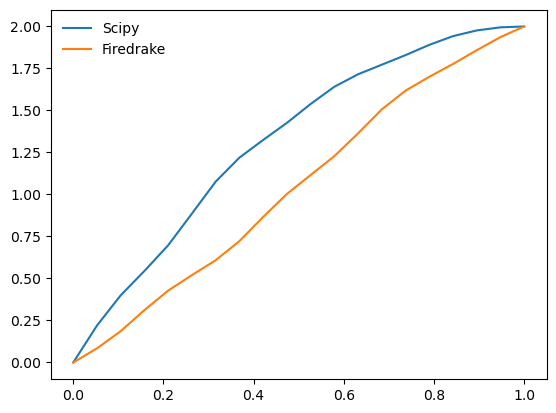

In [26]:
plt.plot(t,y_shock_plot_, label = "Scipy")
plt.plot(t,y_shock_plot,label = "Firedrake")

plt.legend(frameon = False)

In [27]:
alpha_samp,dt_tracker = Metropolis_Hastings(t,noise_sol_test,500000)

/tmp/ipykernel_6816/57740635.py:16: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)


Acceptance Rate: 0.035


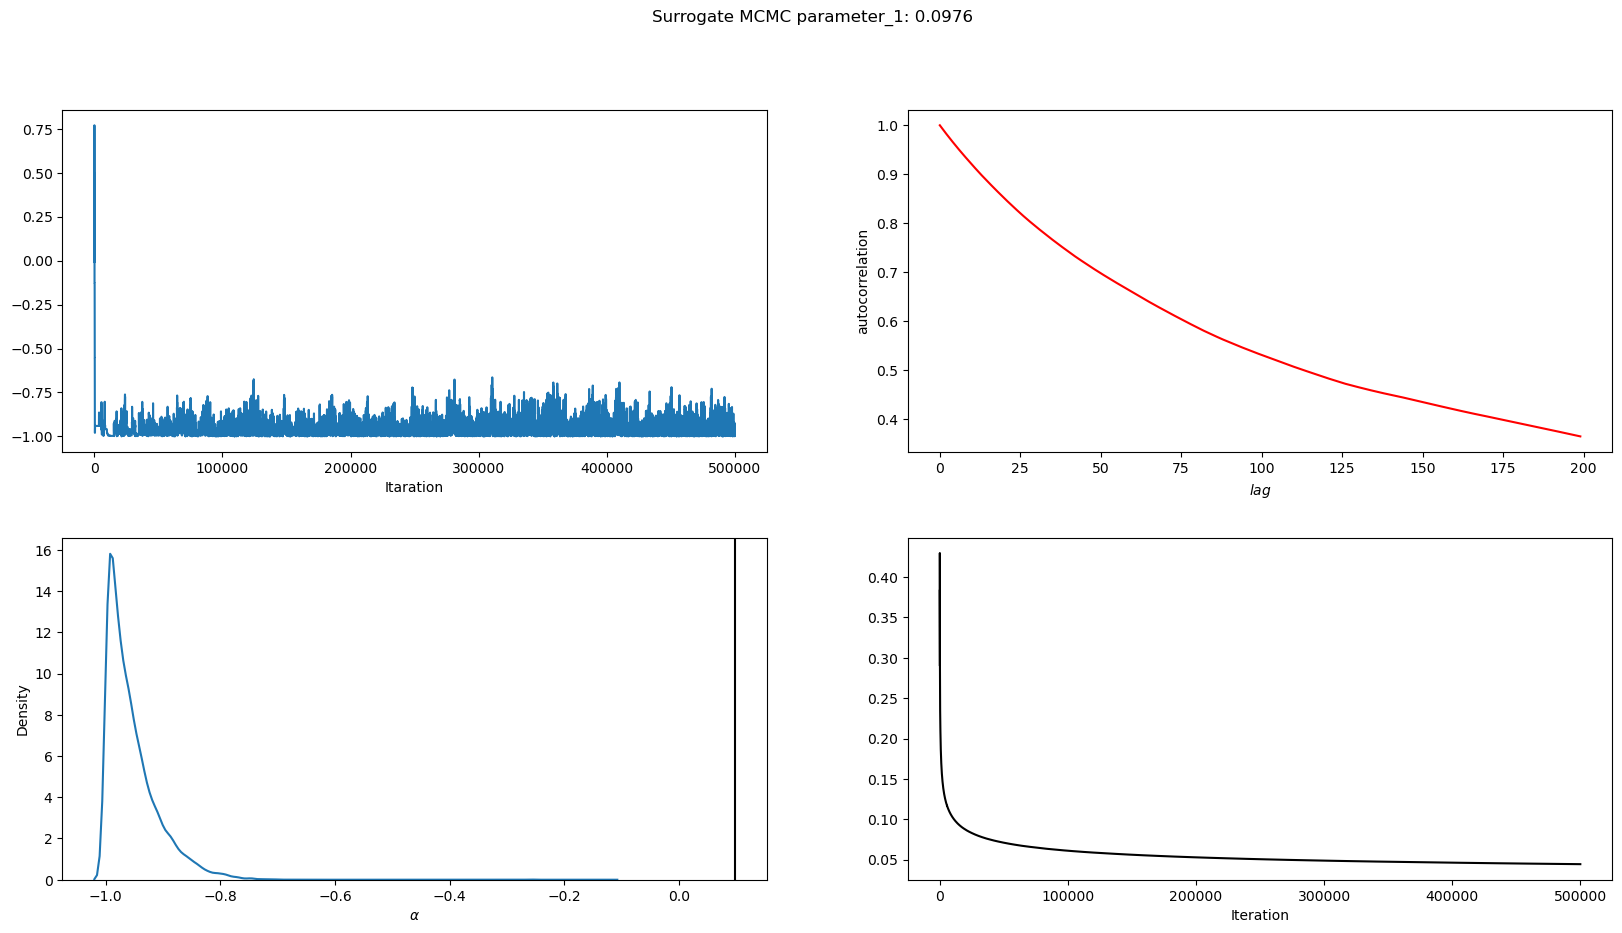

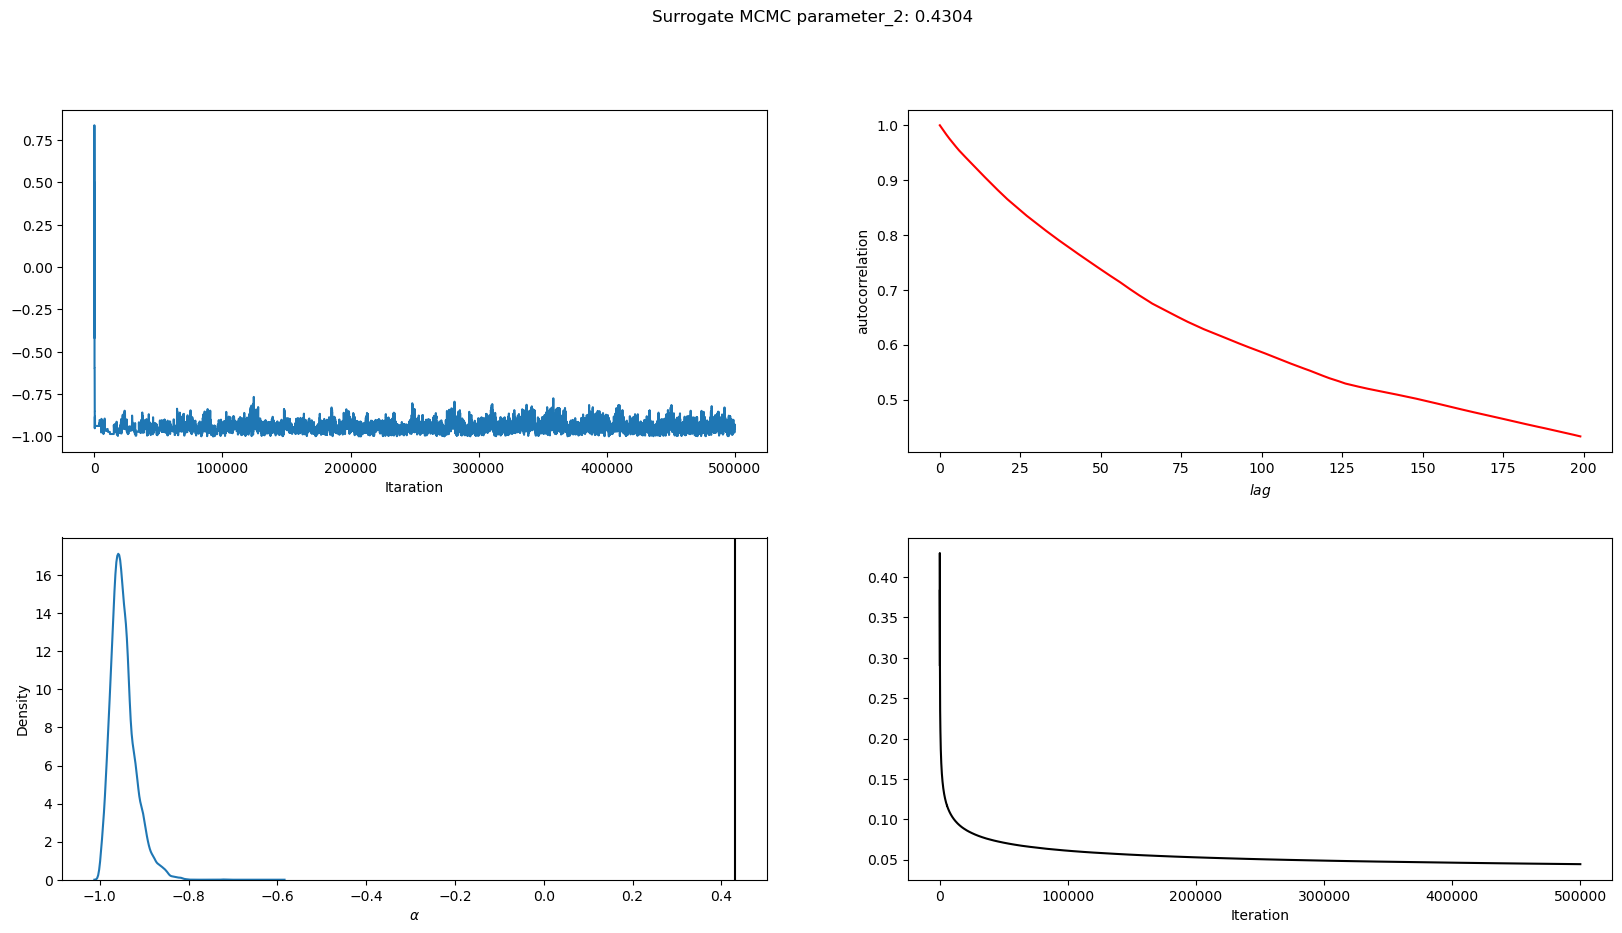

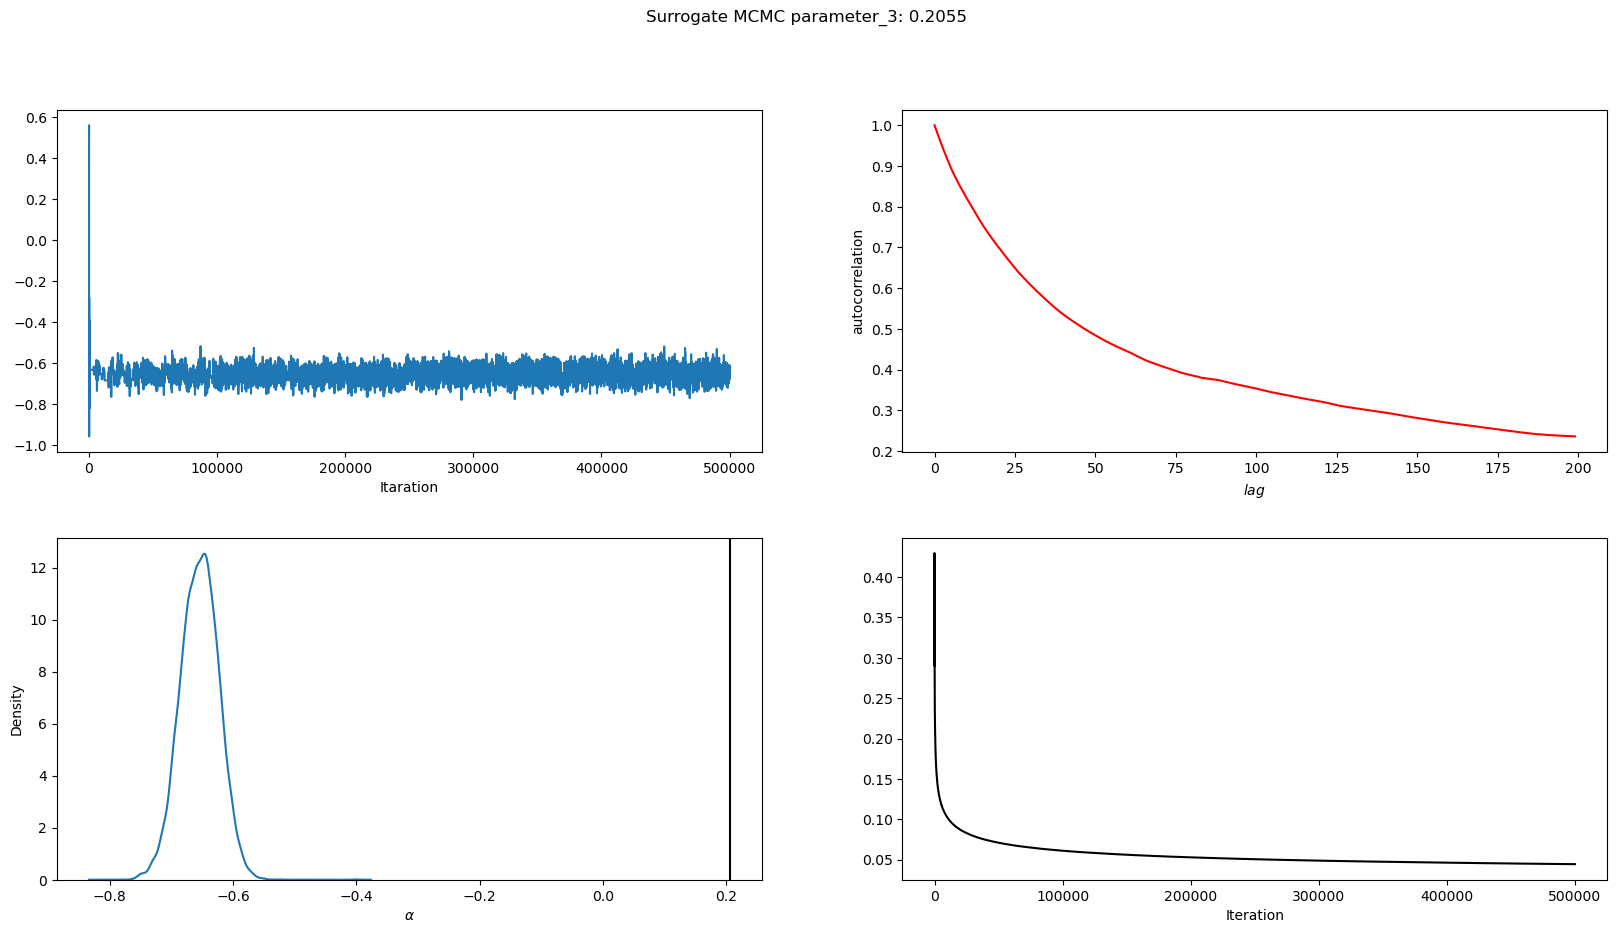

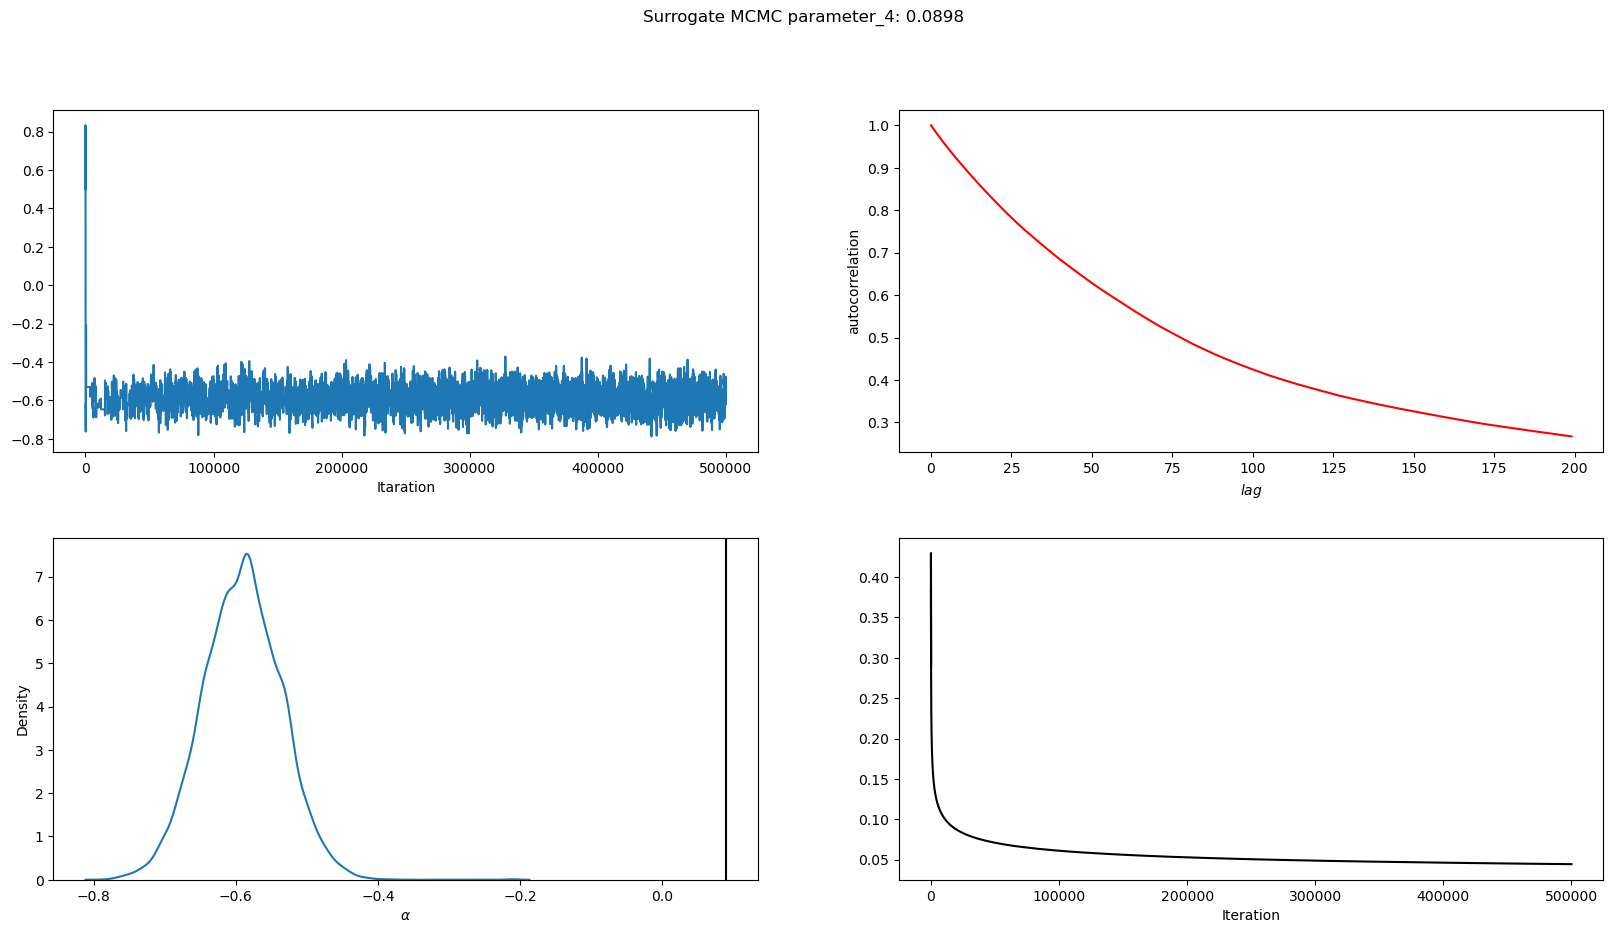

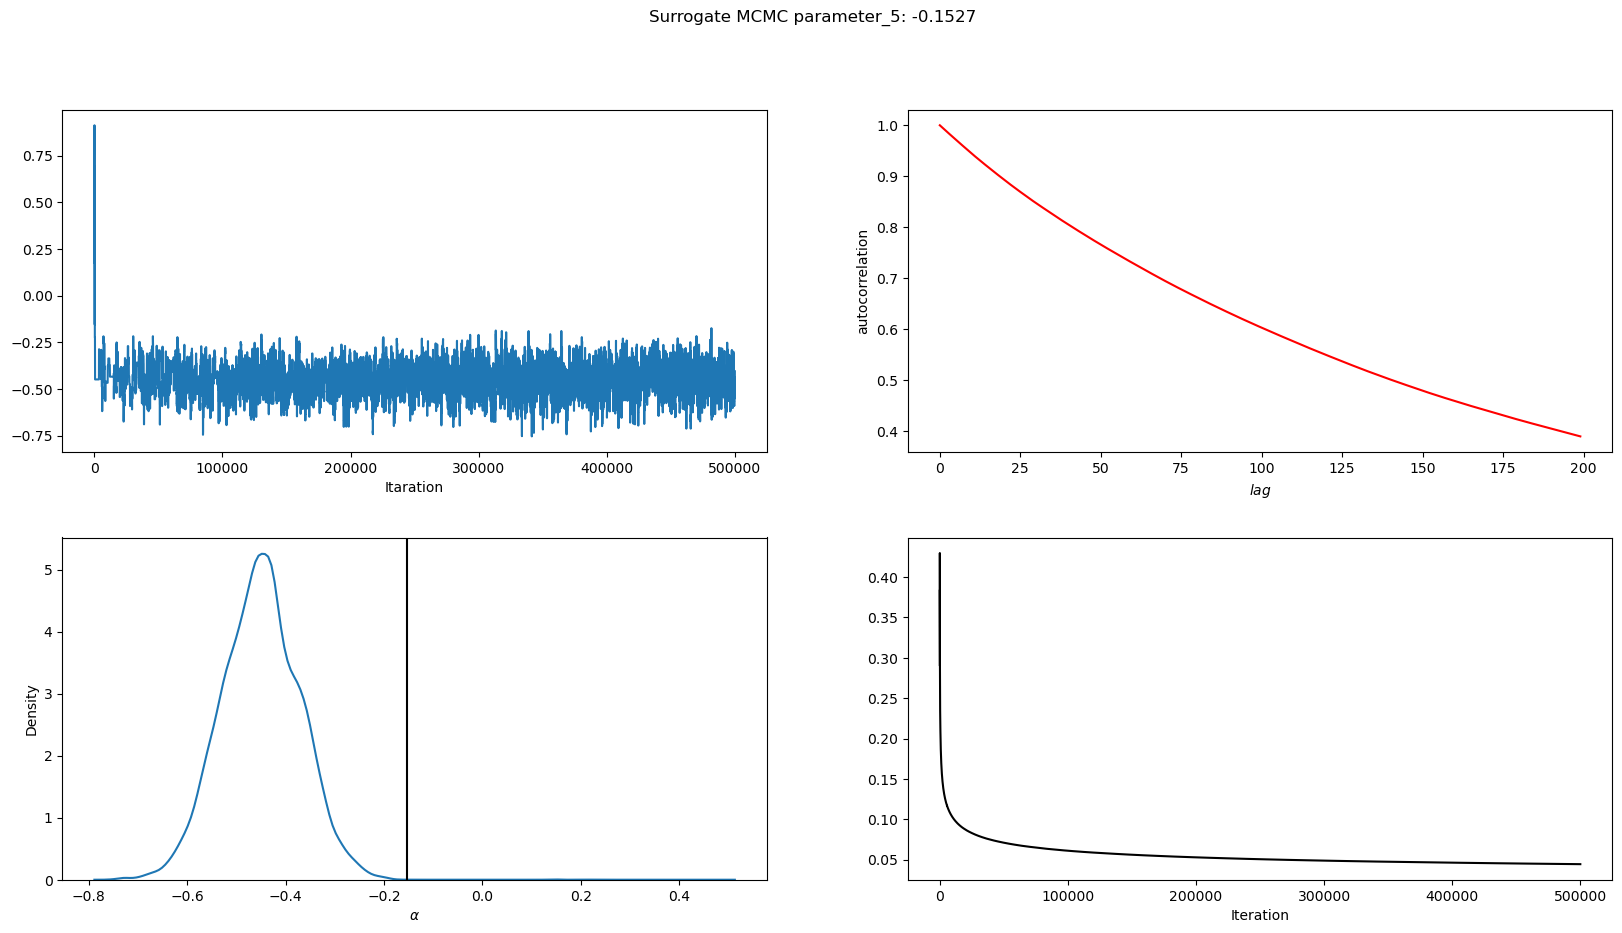

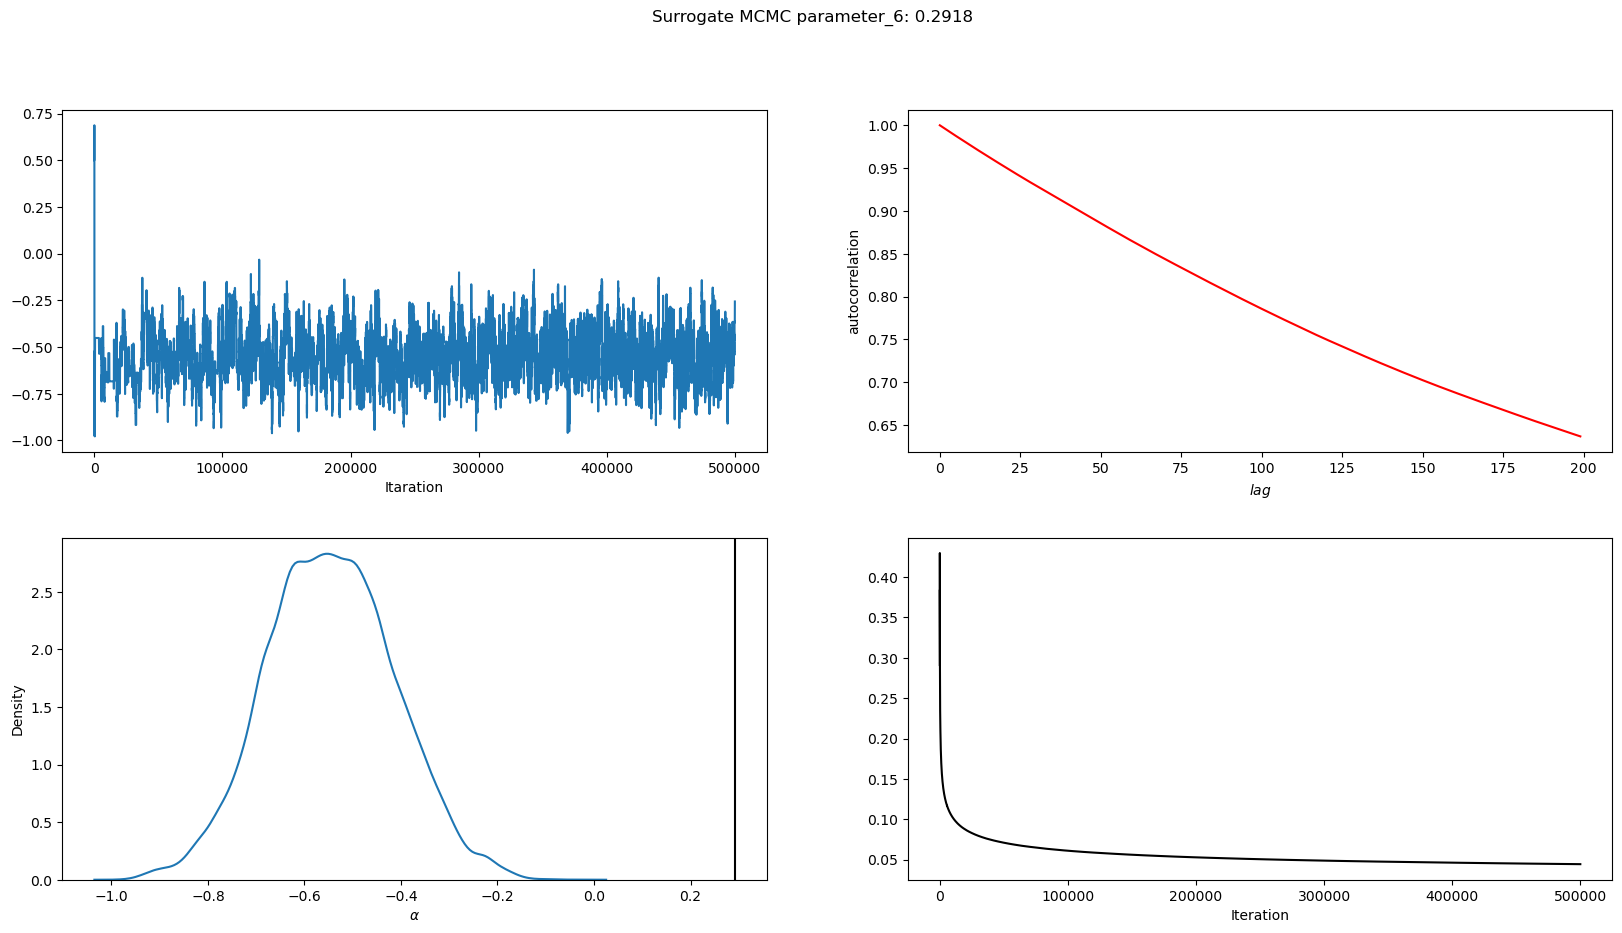

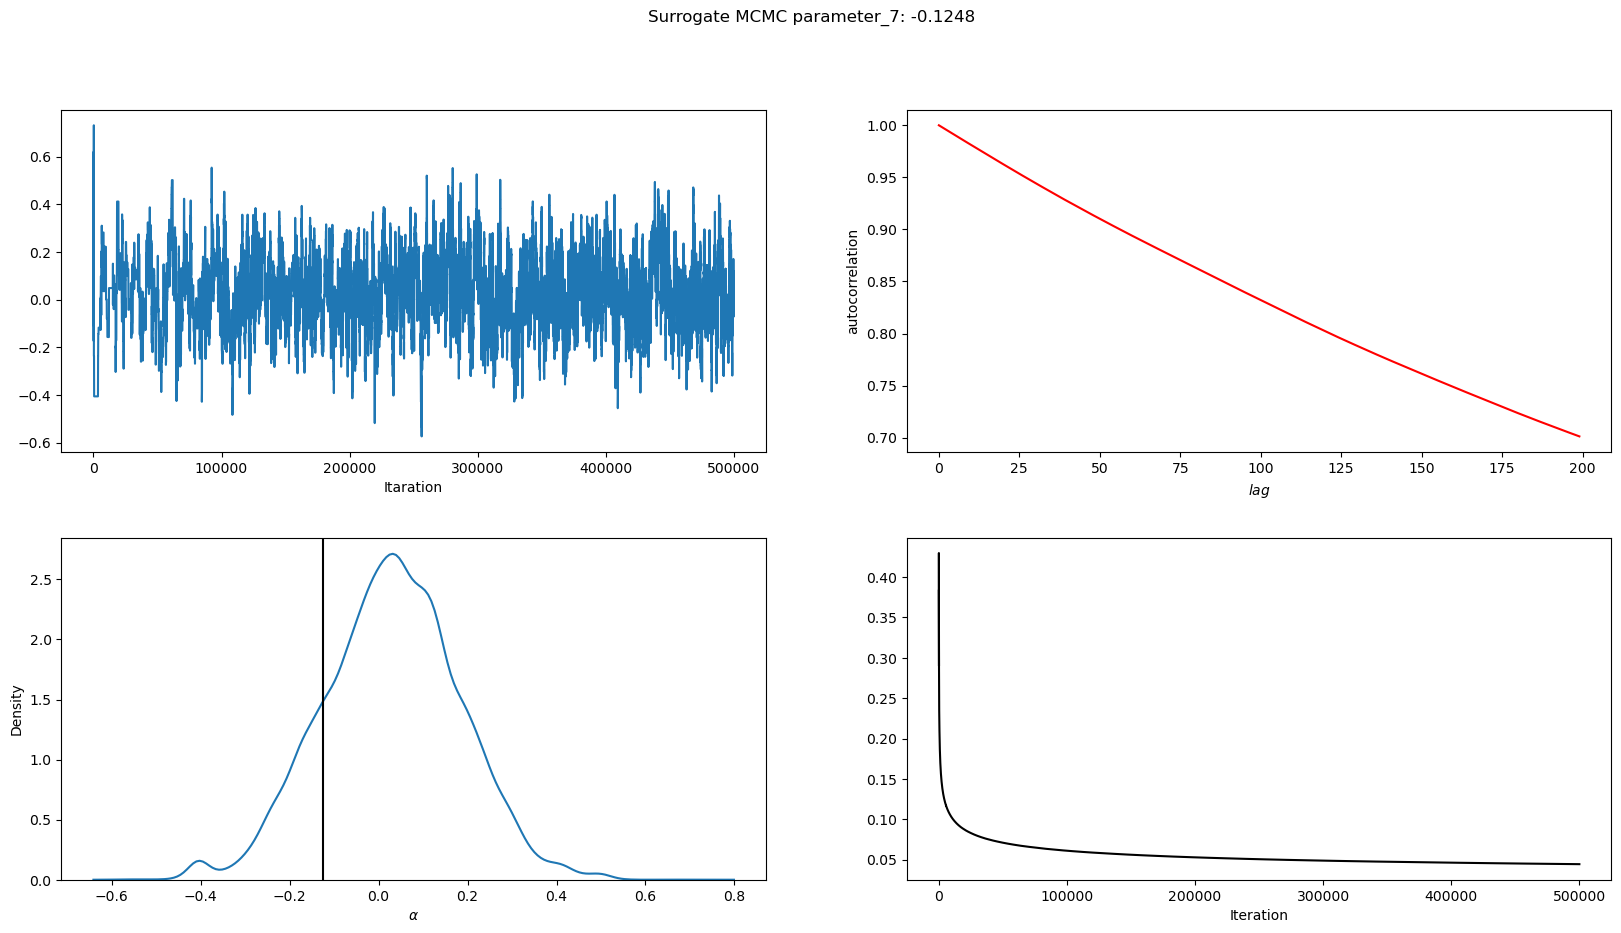

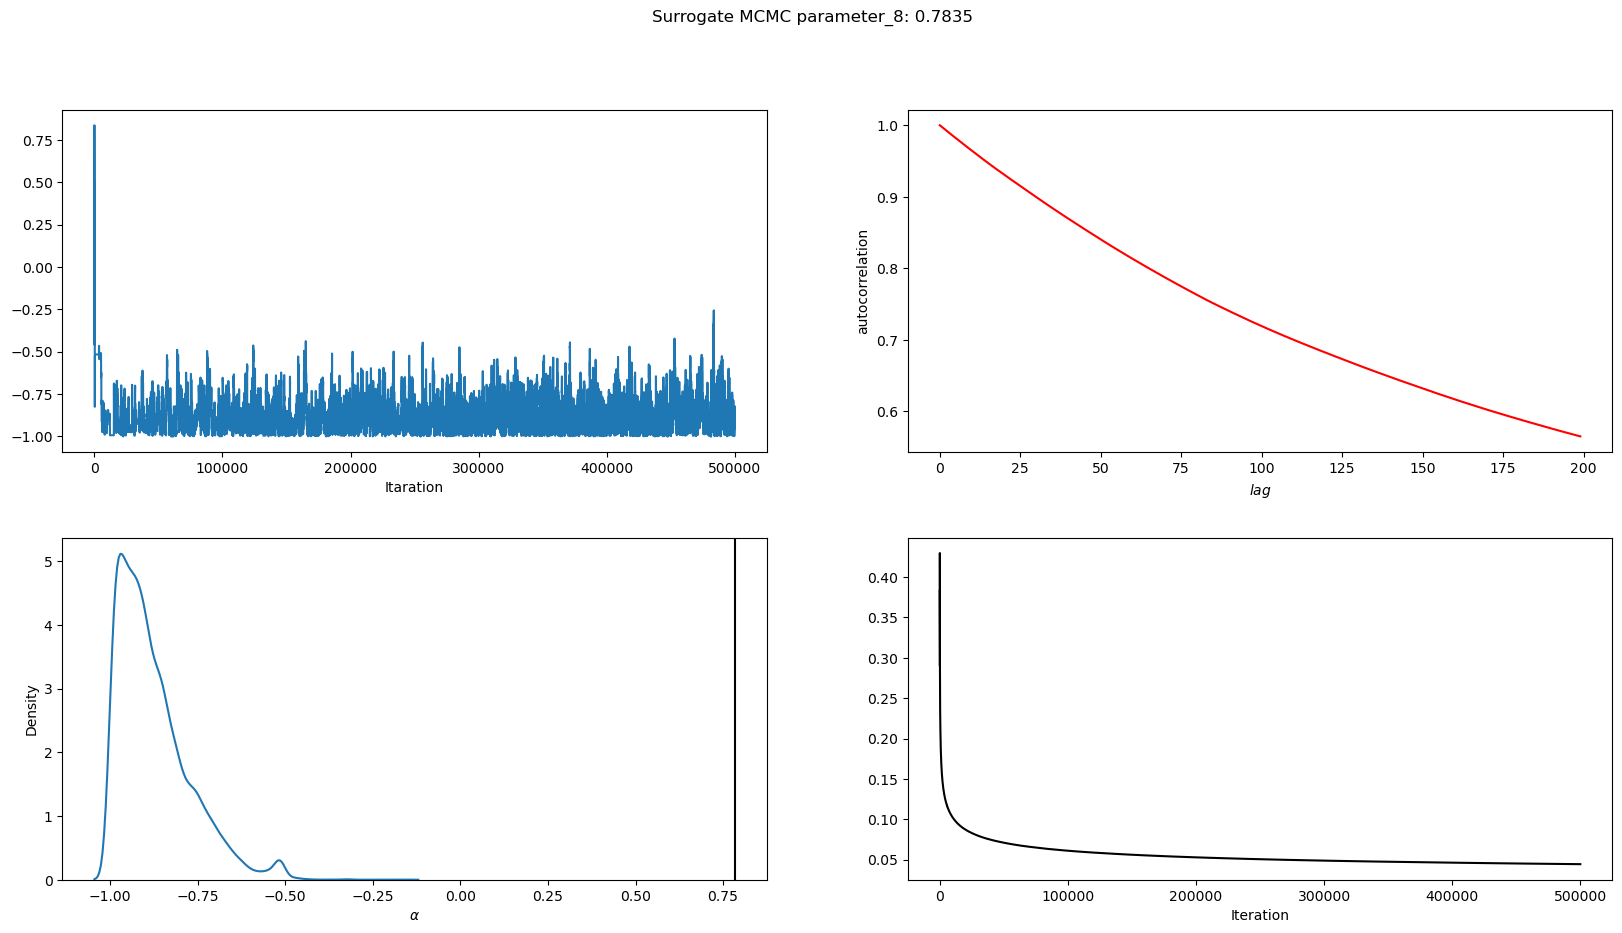

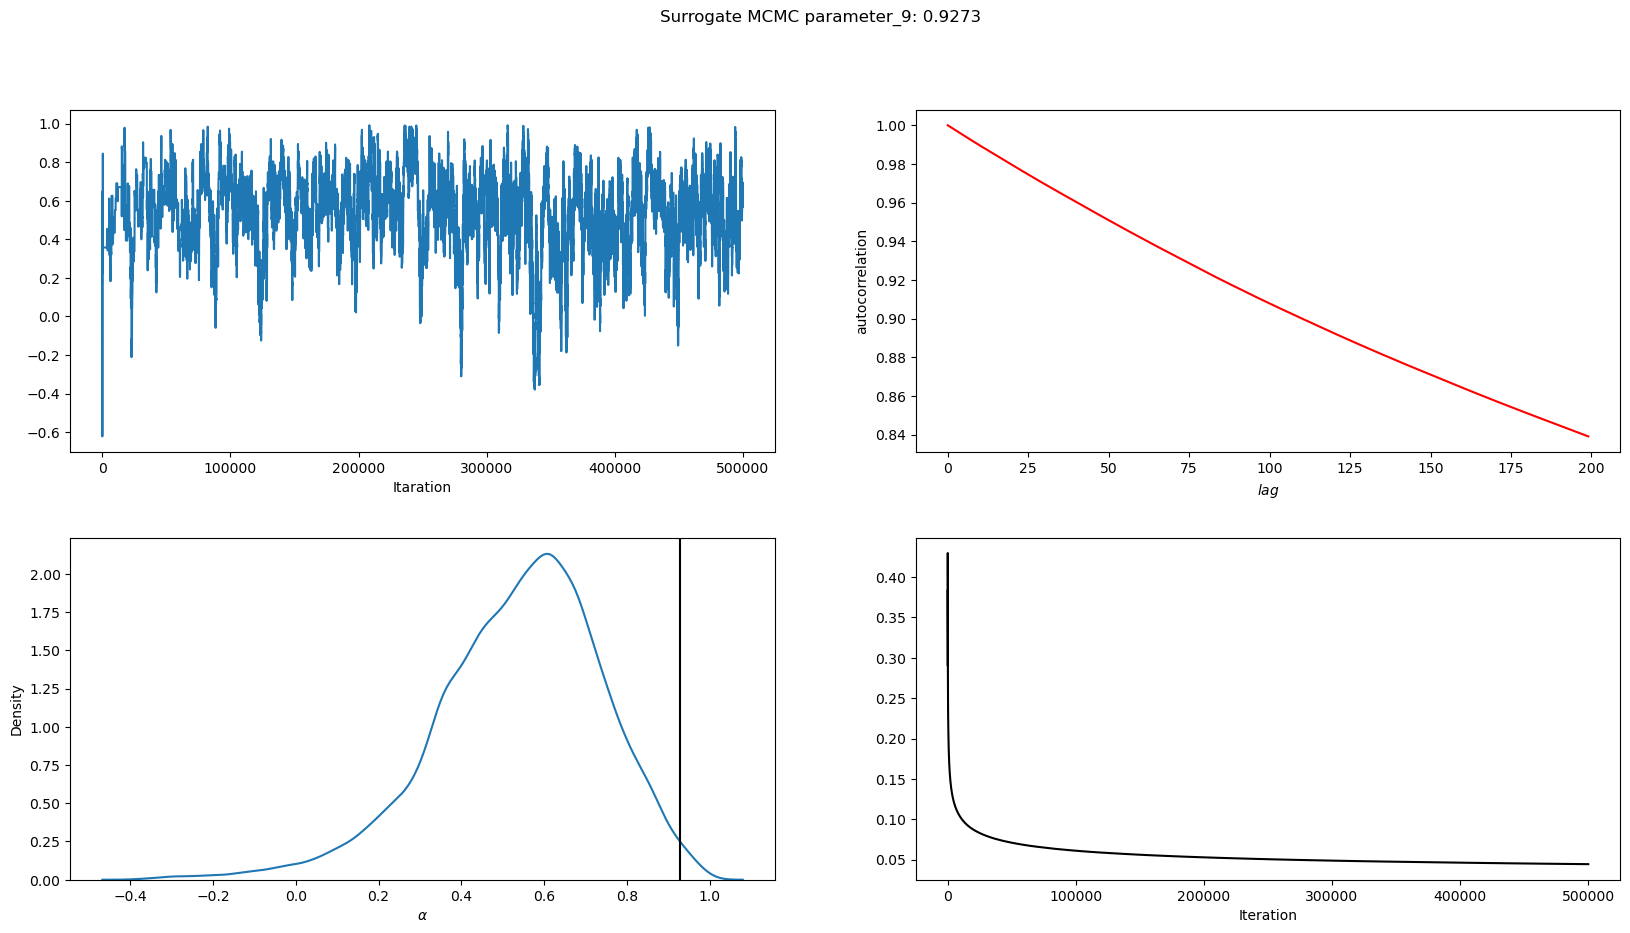

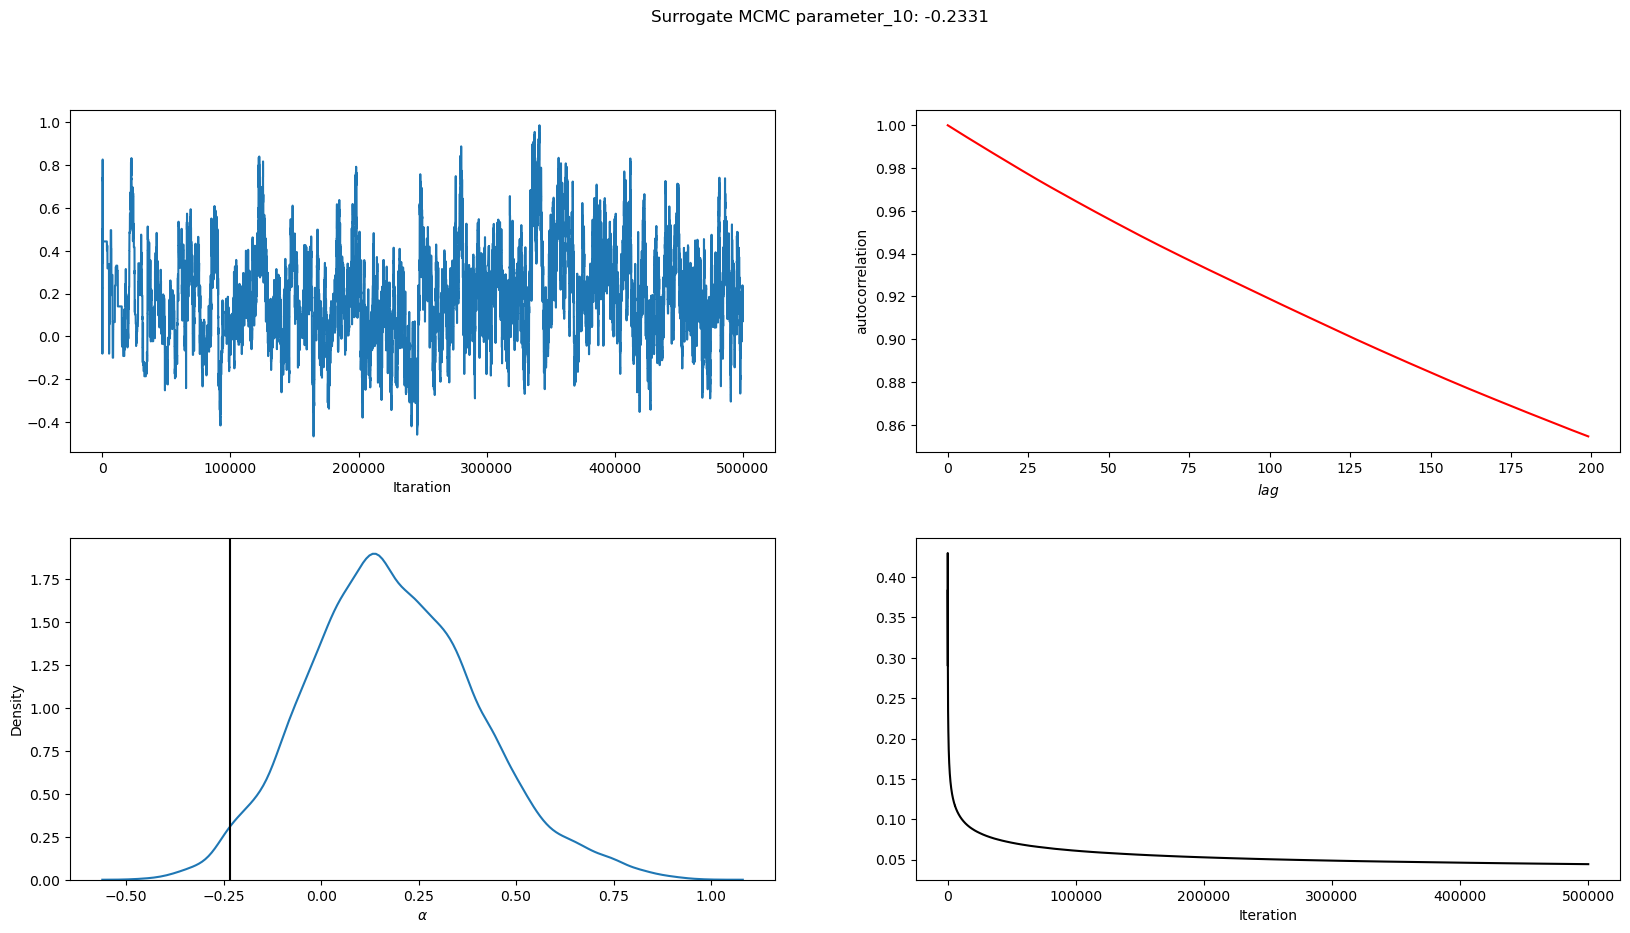

In [28]:
import seaborn as sns

for i in range(alpha_samp.shape[1]):

    fig = plt.figure(figsize=(20,10))

    plt.suptitle(f"Surrogate MCMC parameter_{i+1}: {theta_t[i]:0.4f}")
    plt.subplots_adjust(hspace=0.25)

    plt.subplot(2, 2, 1)
    plt.plot(alpha_samp[:,i])
    plt.xlabel("Itaration")

    plt.subplot(2, 2, 2)
    plt.plot(acf(alpha_samp[:,i],200),color = "red")
    plt.xlabel(r"$lag$")
    plt.ylabel(r"autocorrelation")


    plt.subplot(2, 2, 3)
    #plt.hist(alpha_samp[200:],color = "orange",alpha = 0.5)
    #plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")
    sns.kdeplot(alpha_samp[200:,i],bw_adjust=2)
    plt.axvline(x = theta_t[i], color = 'black', label = 'Real')
    plt.xlabel(r"$\alpha$")
    #plt.xlim(0.3,0.32)

    plt.subplot(2, 2, 4)
    plt.plot(dt_tracker,color = "black")
    plt.xlabel("Iteration")

    plt.plot()

## Scipy Solutions

In [31]:
noise_sol_test = y_shock_plot_ +  np.random.normal(mean,std, len(t))

alpha_samp,dt_tracker = Metropolis_Hastings(t,noise_sol_test,500000)

Acceptance Rate: 0.060


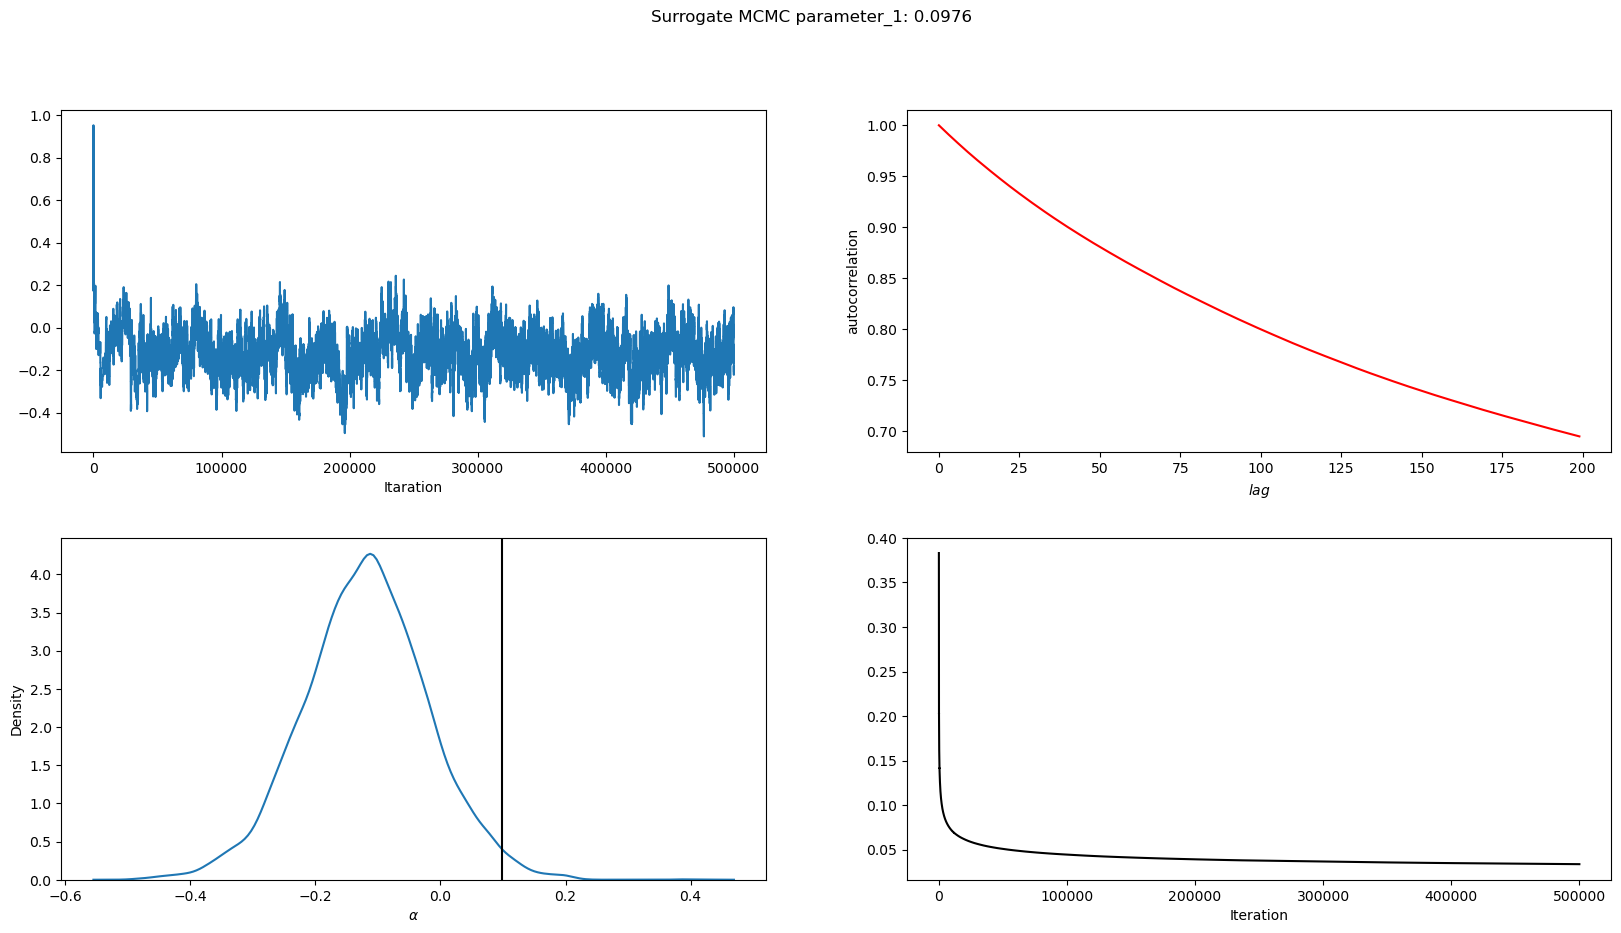

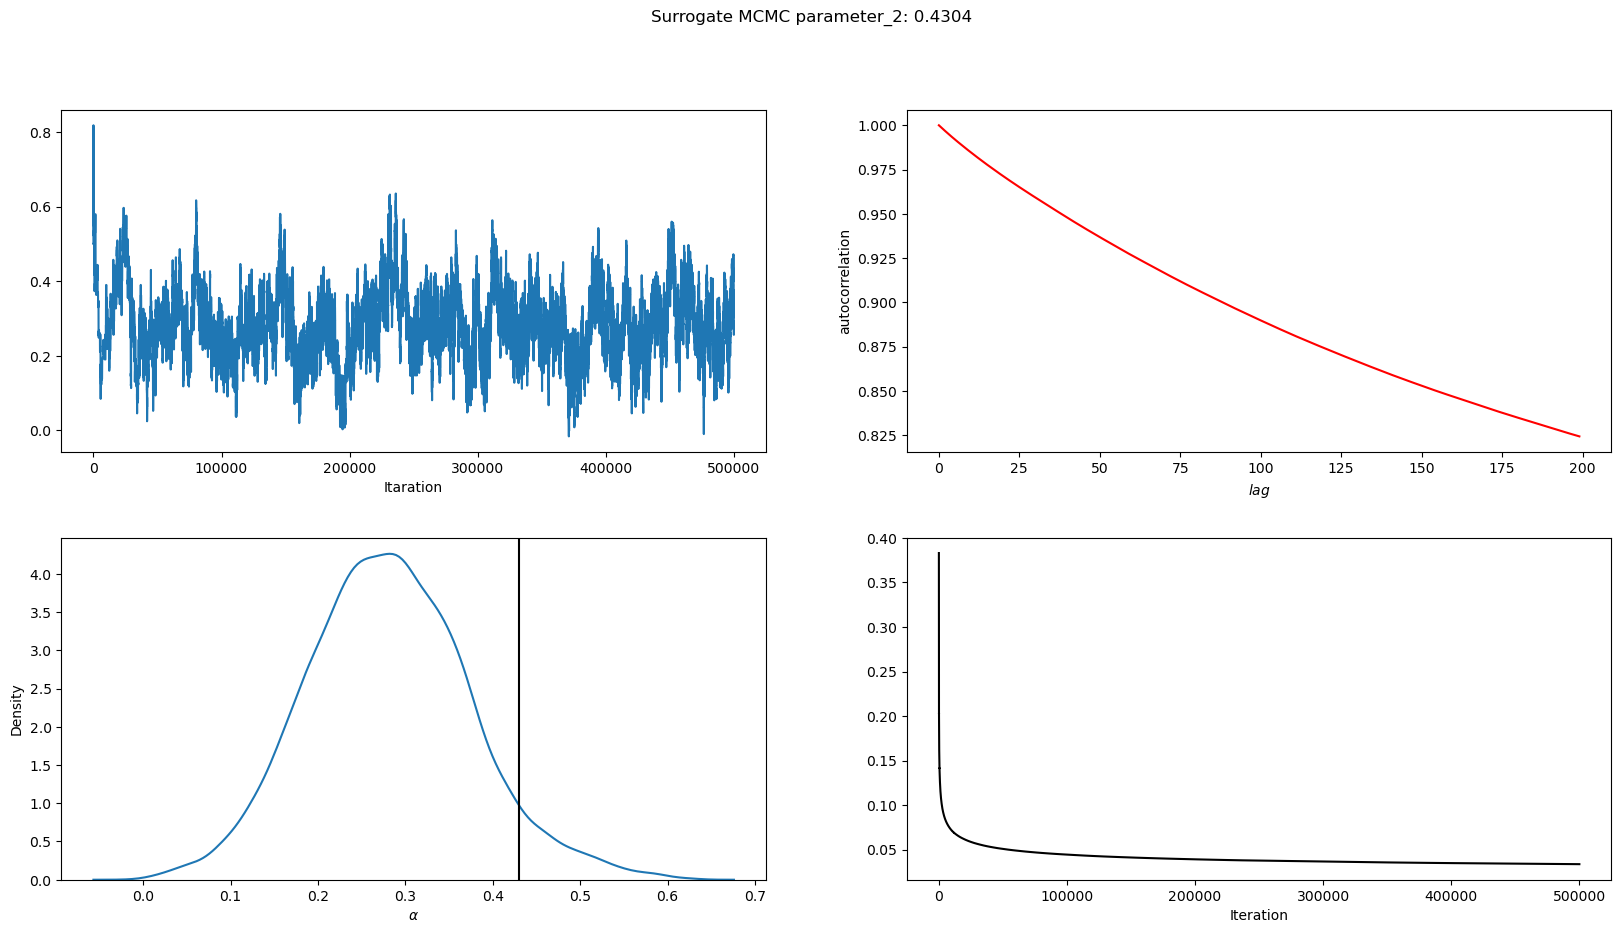

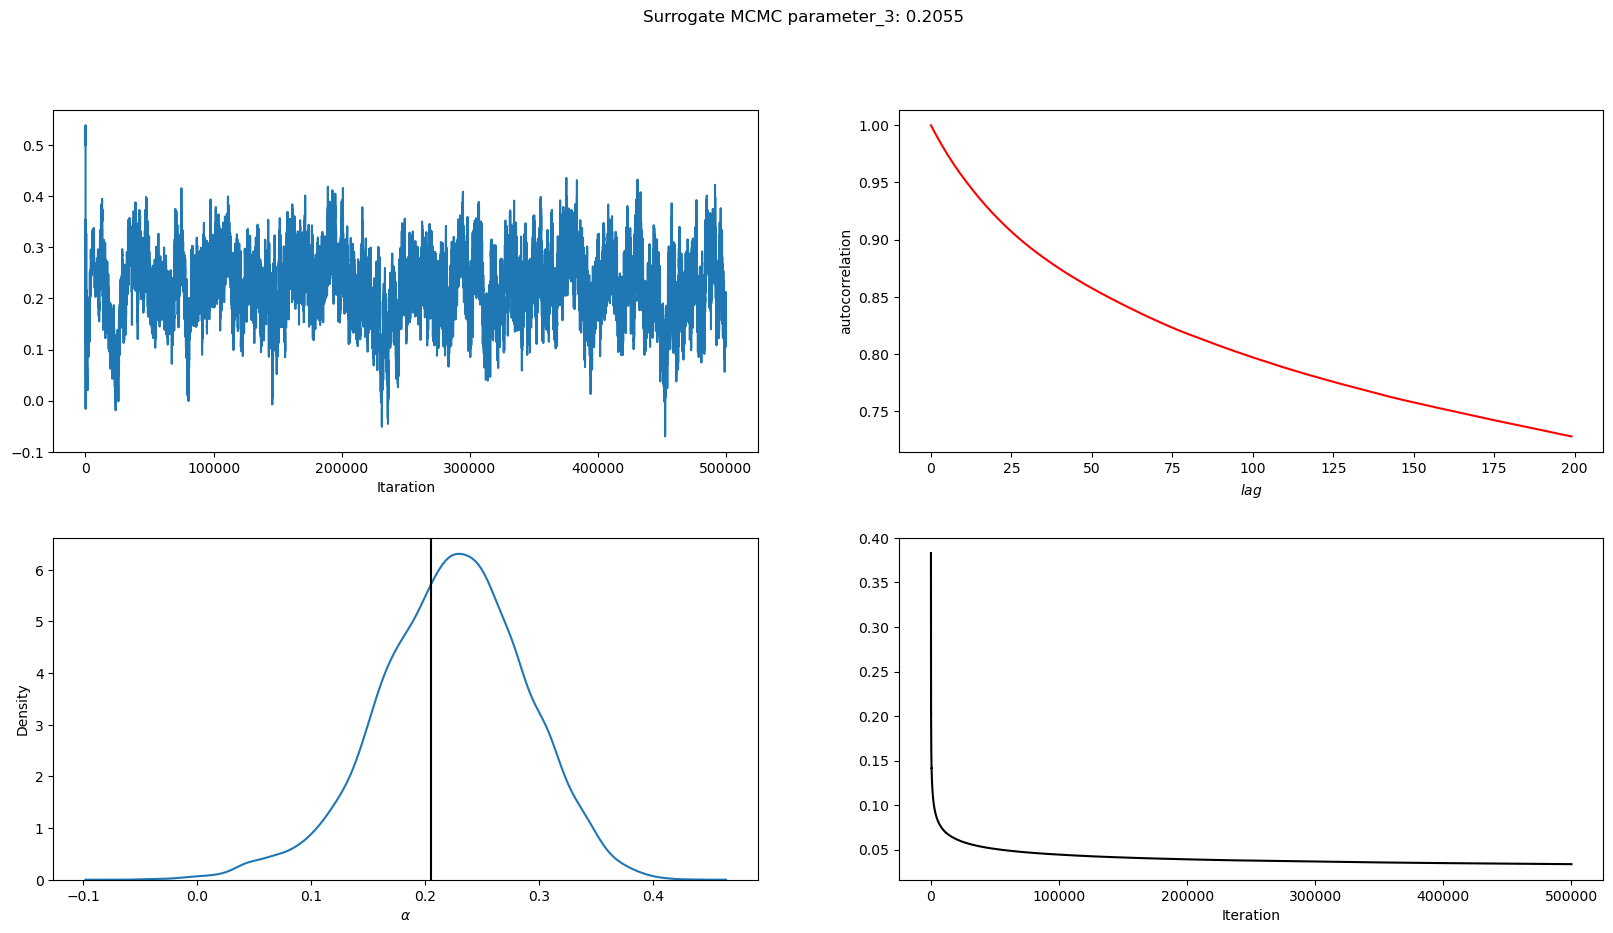

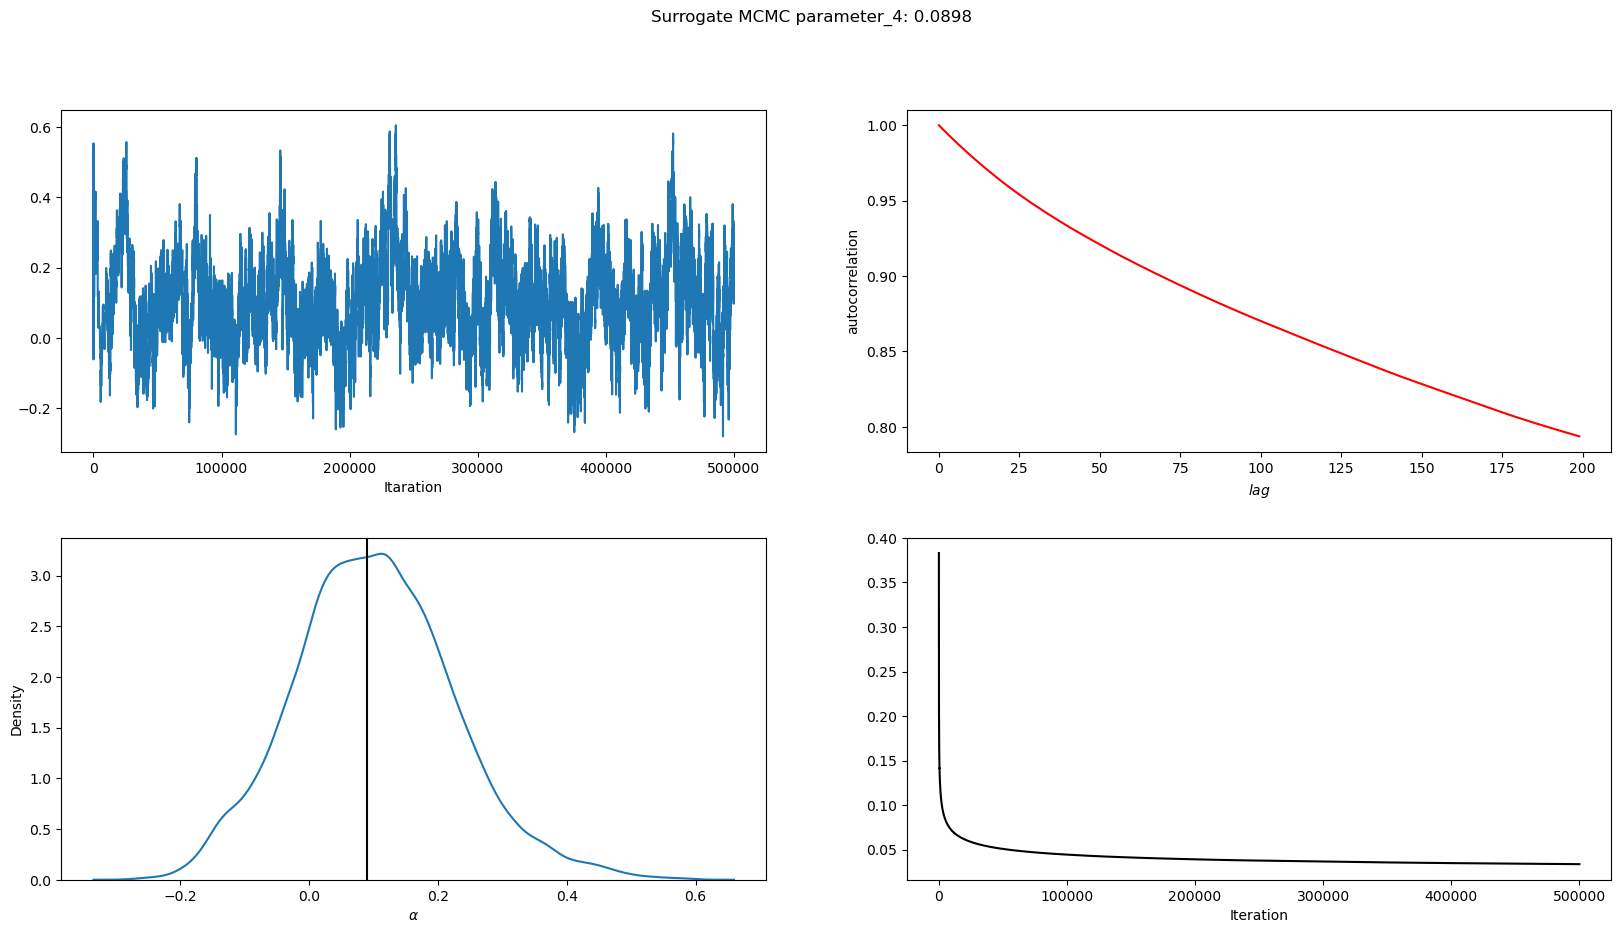

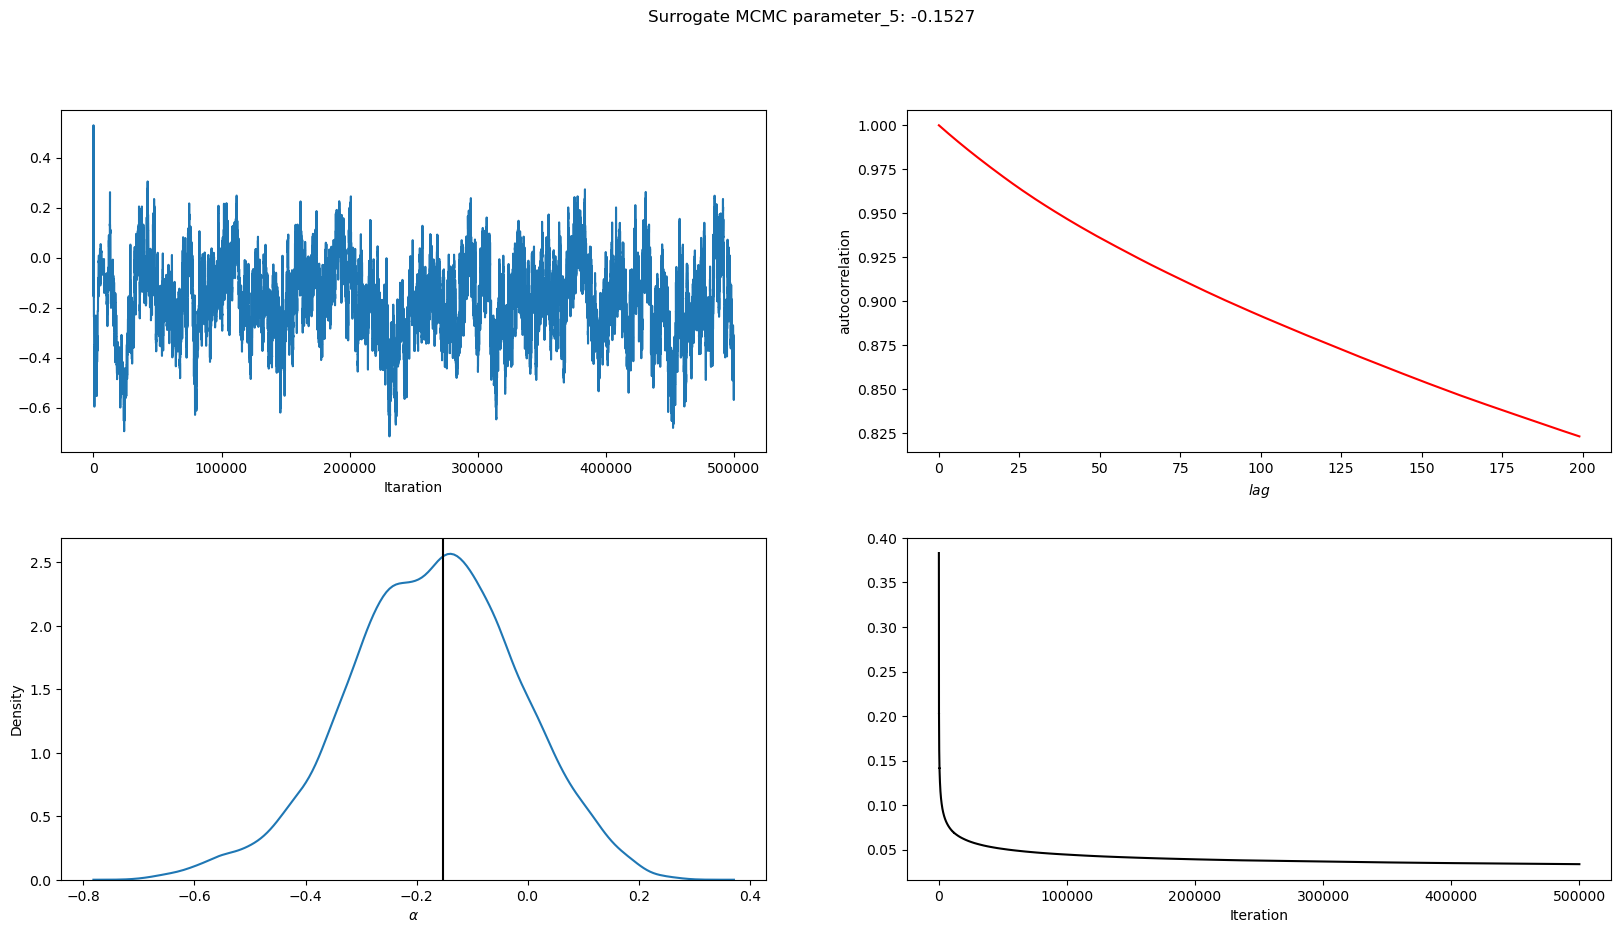

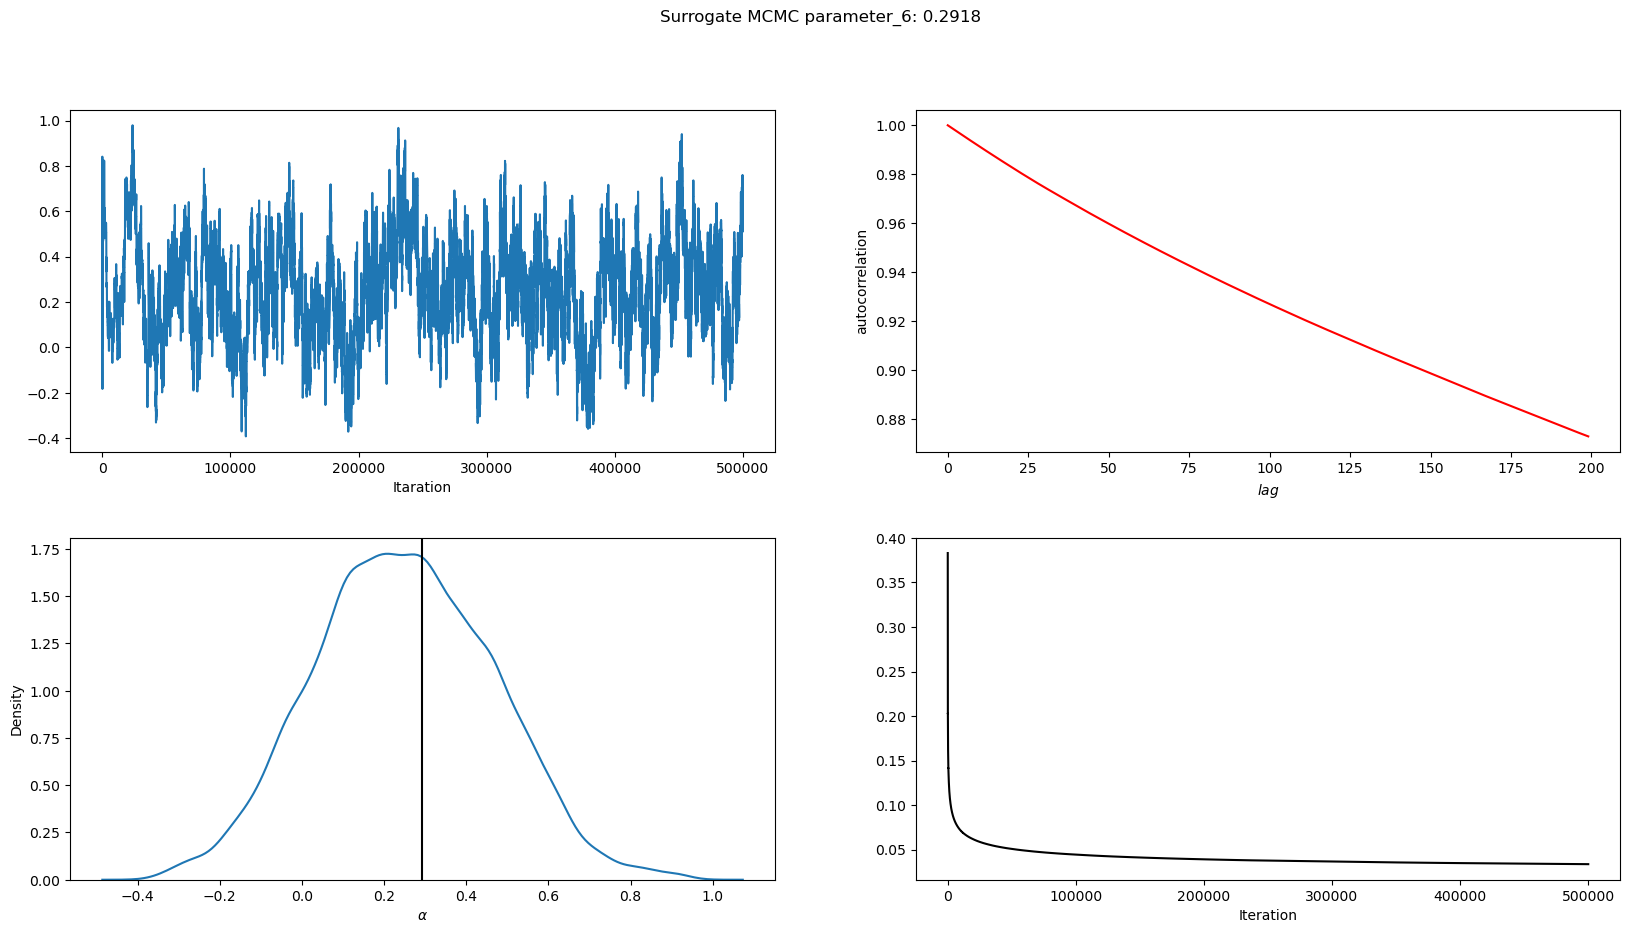

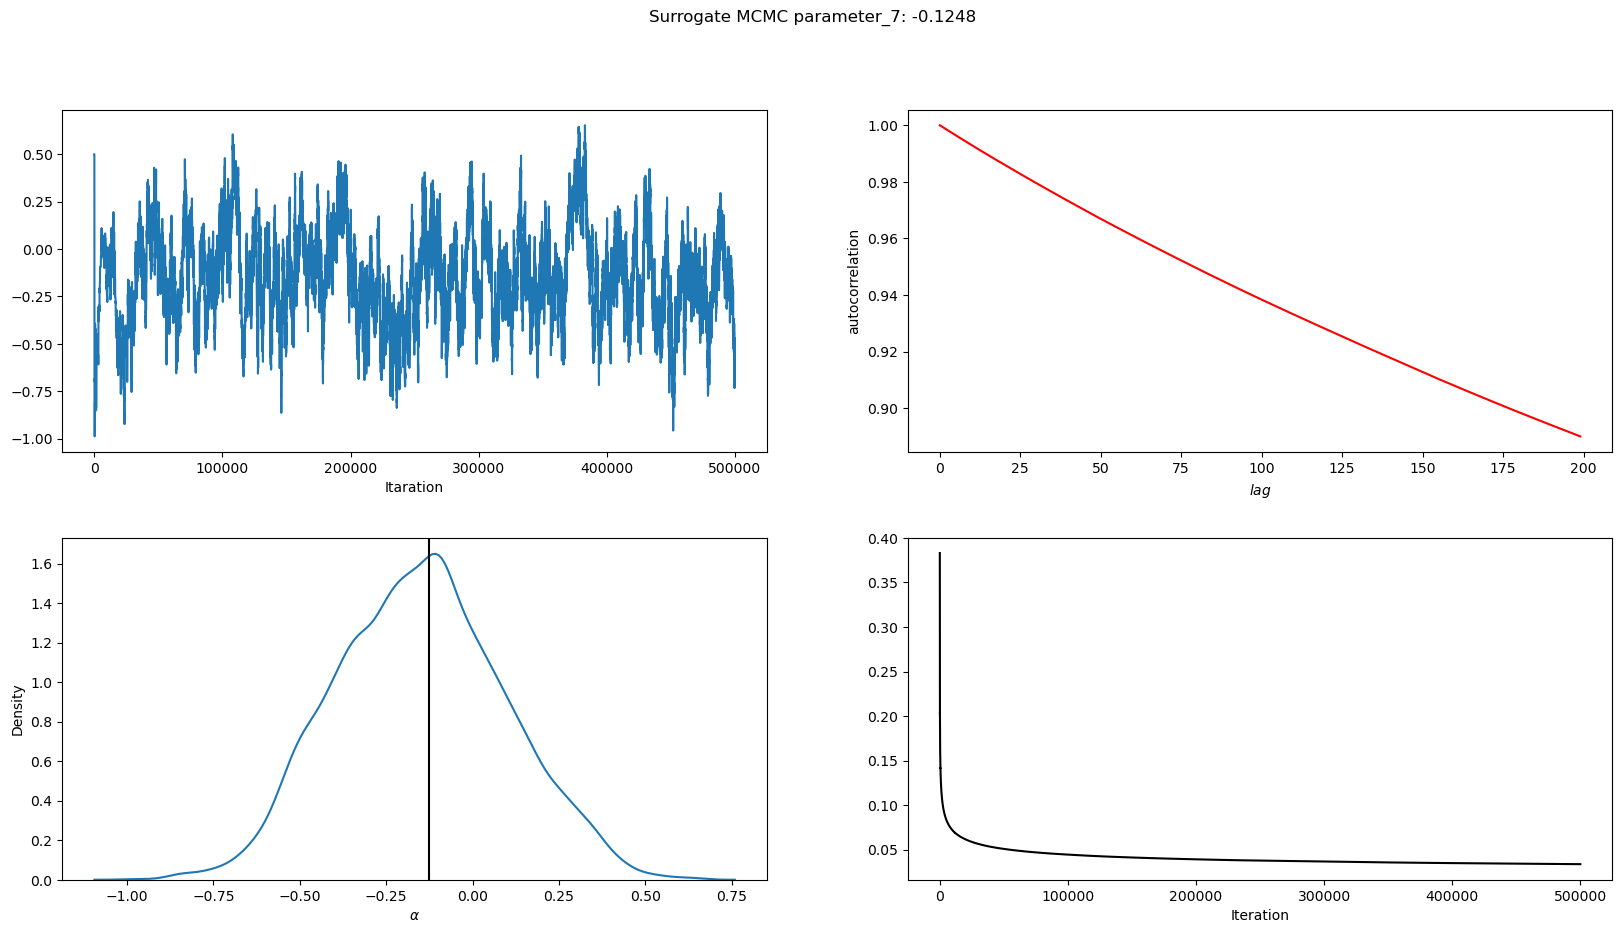

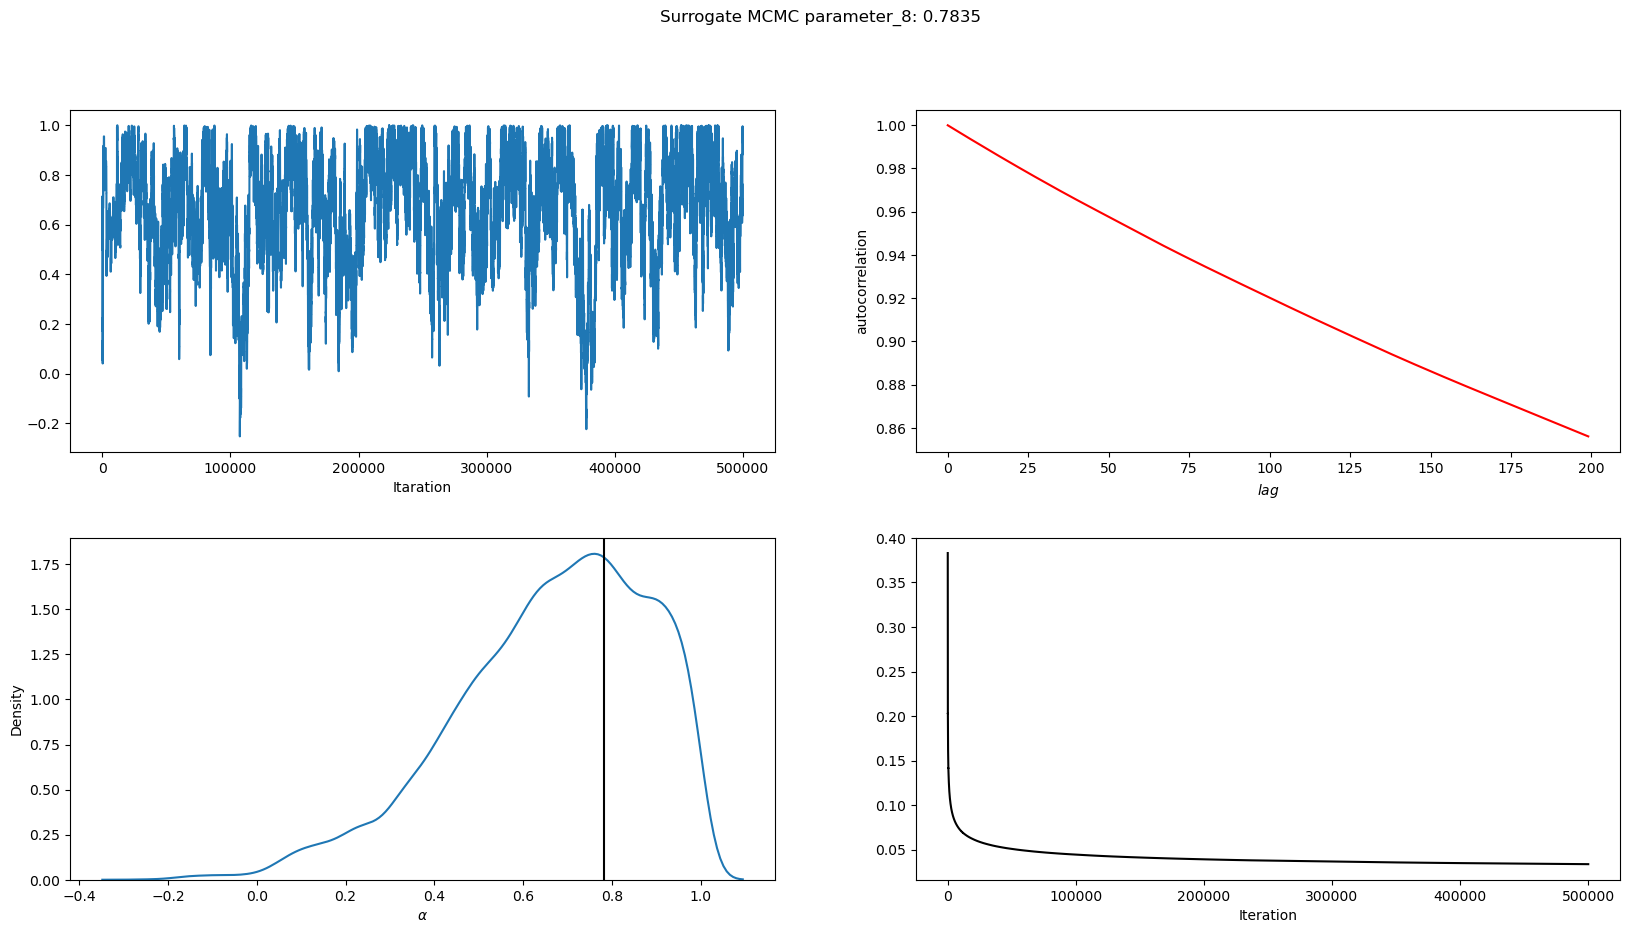

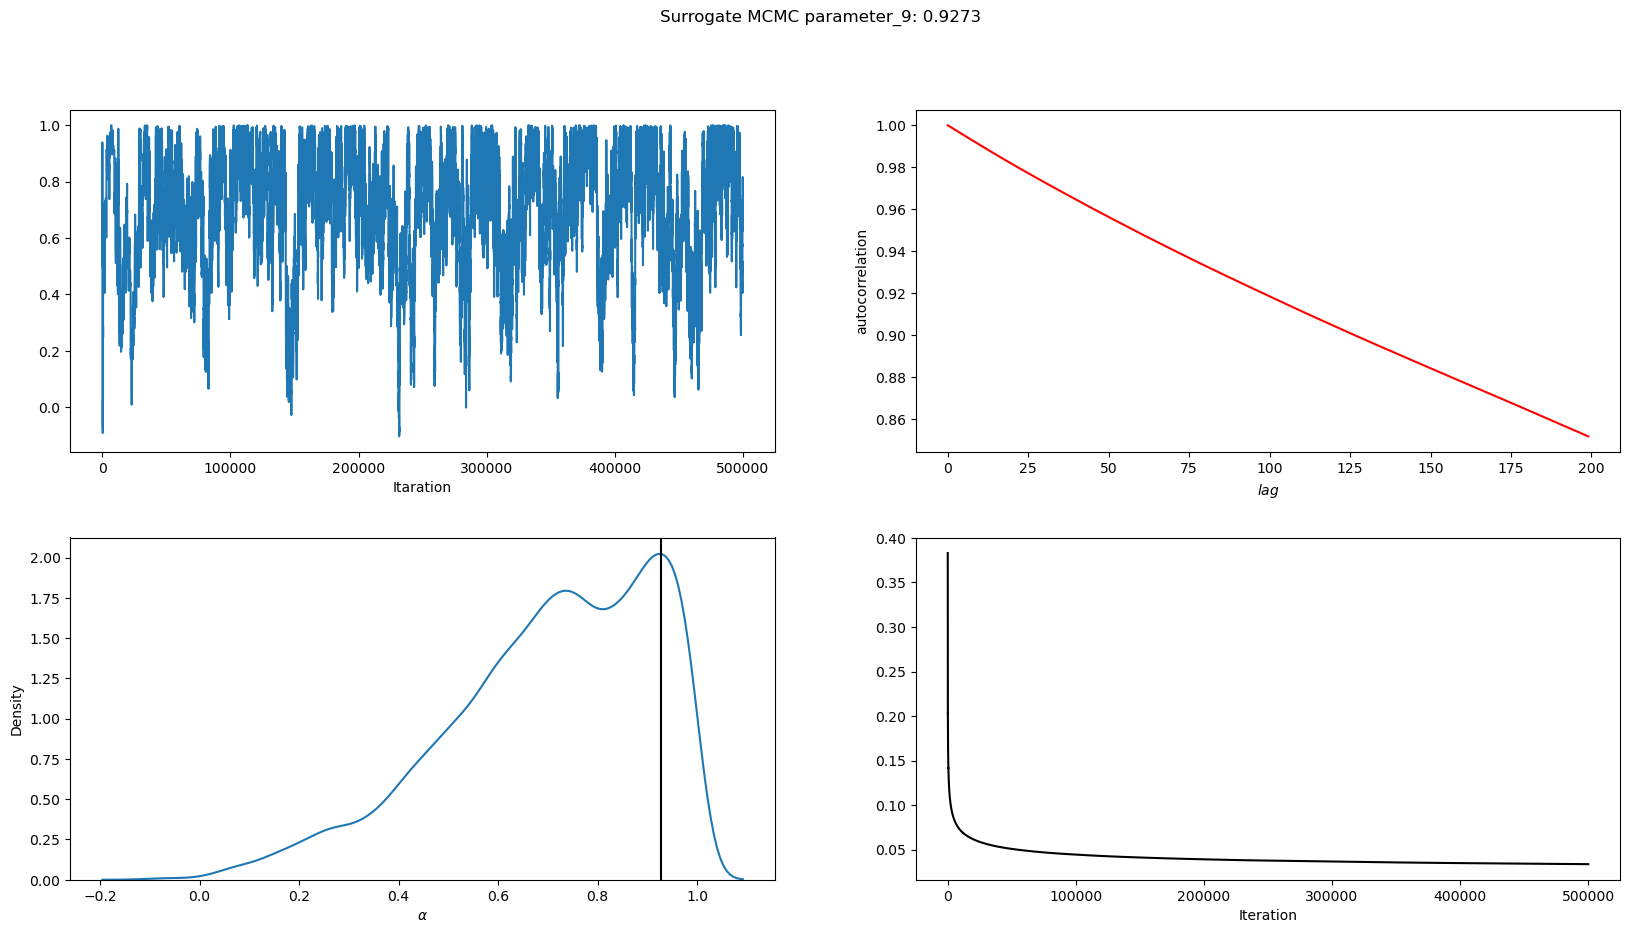

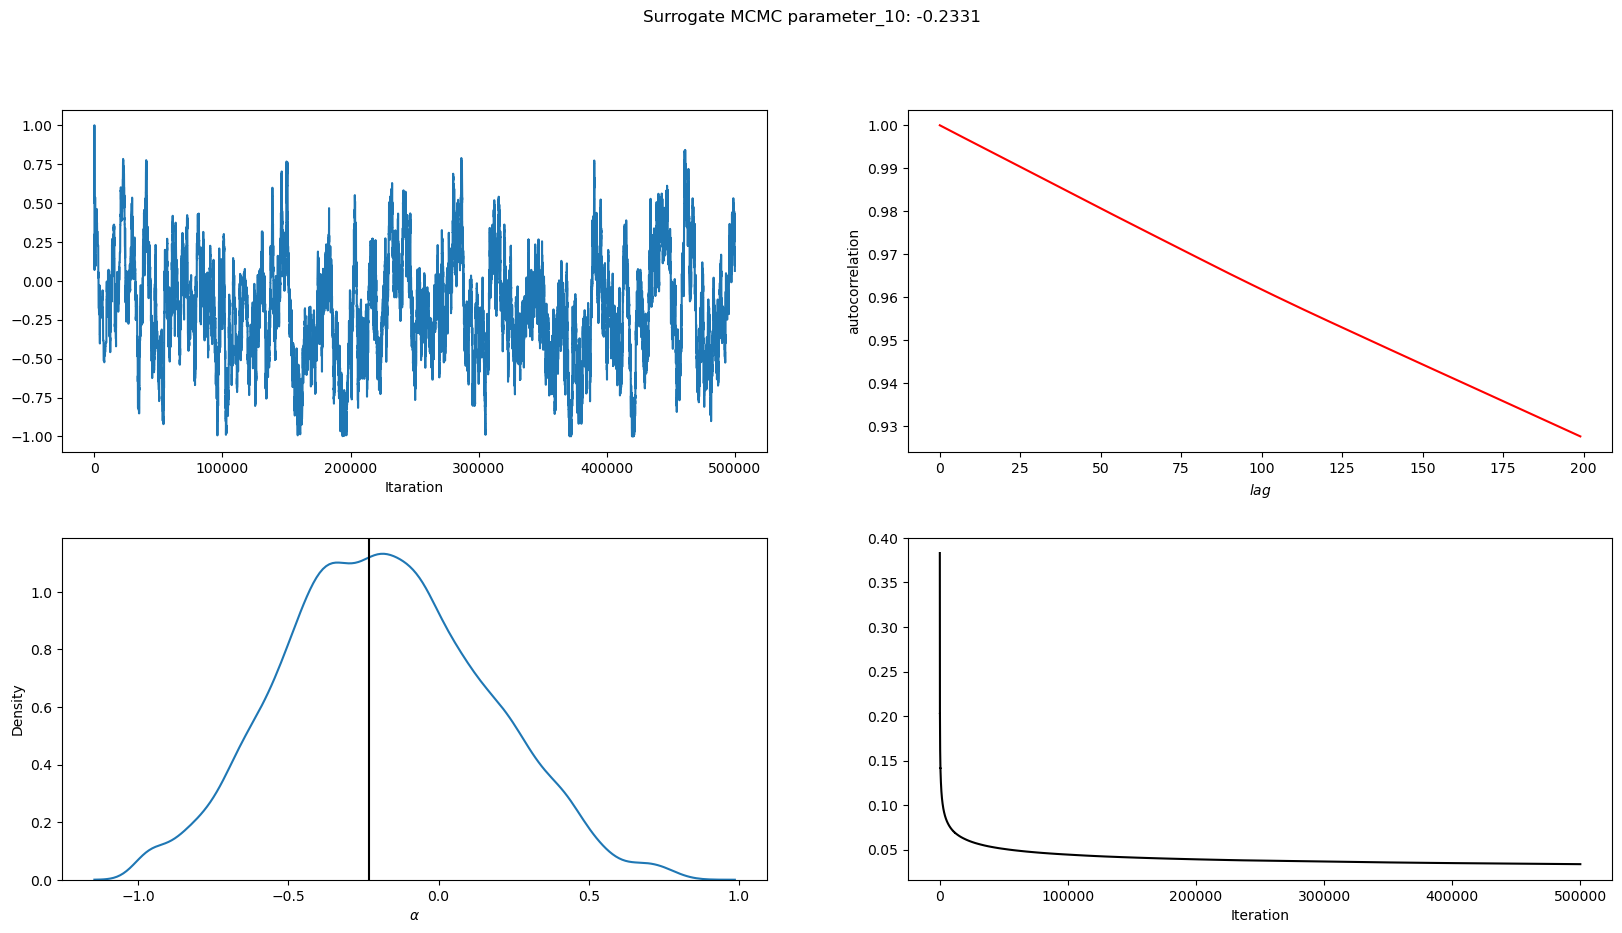

In [32]:
for i in range(alpha_samp.shape[1]):

    fig = plt.figure(figsize=(20,10))

    plt.suptitle(f"Surrogate MCMC parameter_{i+1}: {theta_t[i]:0.4f}")
    plt.subplots_adjust(hspace=0.25)

    plt.subplot(2, 2, 1)
    plt.plot(alpha_samp[:,i])
    plt.xlabel("Itaration")

    plt.subplot(2, 2, 2)
    plt.plot(acf(alpha_samp[:,i],200),color = "red")
    plt.xlabel(r"$lag$")
    plt.ylabel(r"autocorrelation")


    plt.subplot(2, 2, 3)
    #plt.hist(alpha_samp[200:],color = "orange",alpha = 0.5)
    #plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")
    sns.kdeplot(alpha_samp[200:,i],bw_adjust=2)
    plt.axvline(x = theta_t[i], color = 'black', label = 'Real')
    plt.xlabel(r"$\alpha$")
    #plt.xlim(0.3,0.32)

    plt.subplot(2, 2, 4)
    plt.plot(dt_tracker,color = "black")
    plt.xlabel("Iteration")

    plt.plot()